In [260]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter

from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from numpy import random
import numpy as np

from sklearn.manifold import TSNE

In [261]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [262]:
bs = 32
Train = False
Resume = False
game = 'amidar'
if game == 'breakout':
    vae_type = 'vae' # vae, betavae, betatcvae
    clustering = 'stdb' # hir, sc, hdb, stdb
    reduce_model = 'umap' # umap, tsne, none
    num_component = 2
    n_neighbors = 30 # UMAP parameter default 15, 30 is better
    min_dist = 0.1 # UMAP parameter default 0.1
    ep1 = [1.2, 0.3, 0.1, 0.15, 0.1, 0.7] # A2C, ApeX, DQN, ES, GA, Rainbow
    ep2 = 15
    min_samples = 8
    num_clusters = 4
    cluser_size = 150
else:
    vae_type = 'vae' # vae, betavae, betatcvae
    clustering = 'stdb' # hir, sc, hdb, stdb
    reduce_model = 'umap' # umap, tsne, none
    num_component = 2
    n_neighbors = 30 # UMAP parameter default 15, 30 is better
    min_dist = 0.1 # UMAP parameter default 0.1
    ep1 = [0.1, 0.2, 0.2, 0.1, 0.1, 0.2] # A2C, ApeX, DQN, ES, GA, Rainbow
    ep2 = 15
    min_samples = 8
    num_clusters = 4
    cluser_size = 150
random.seed(1)
torch.manual_seed(1)
writer = SummaryWriter('./runs/' + vae_type + '_' + game)

In [263]:
s_epochs = 0
d_epochs = 60
epochs = s_epochs + d_epochs

In [264]:
# Load Data for Training VAE
dataset = datasets.ImageFolder(root='./torch_images_label/' + game, transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
]))
train_size = int(0.8 * len(dataset.imgs))
test_size = len(dataset.imgs) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
eval_dataloader = torch.utils.data.DataLoader(eval_dataset, batch_size=bs, shuffle=False)
len(dataset.imgs), len(dataloader)

(15001, 375)

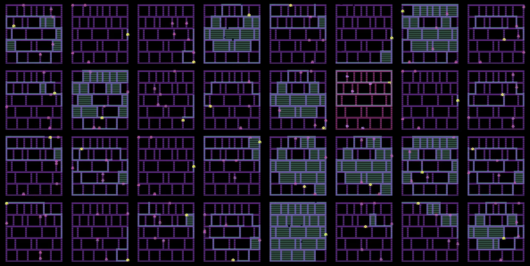

In [265]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, './saved_images/'+ game + '/input_image.png')

Image('./saved_images/'+ game + '/input_image.png')

In [266]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [267]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [268]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.z_size = z_dim
        self.kl_tolerance = 0.5
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            #nn.ReLU(),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z
    
    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

    
    def loss_fn(self, recon_x, x, mu, logvar, *arg):
        recons_loss = torch.mean(F.binary_cross_entropy(recon_x, x, reduction='sum'))
        #recons_loss = F.mse_loss(recon_x, x)

        # From https://worldmodels.github.io/ 
        # and https://github.com/hardmaru/WorldModelsExperiments/blob/master/carracing/vae/vae.py
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
        KLD = torch.tensor([max(KLD, self.kl_tolerance * self.z_size)])

        return recons_loss + KLD, recons_loss, KLD

In [269]:
class BetaVAE(VAE):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, ep=0):
        super().__init__(image_channels, h_dim, z_dim)
        self.z_dim = z_dim
        self.beta = 5
        self.gamma = 1
        self.C_max = torch.Tensor([500])
        self.C_stop_iter = 1e5
        self.num_iter = ep*len(dataloader) 

  
    def loss_fn(self, recon_x, x, mu, logvar, *arg):
        self.num_iter += 1
        kld_weight = self.z_dim/ x.shape[0]
        
        recons_loss = torch.mean(F.binary_cross_entropy(recon_x, x, reduction='sum'))
        #recons_loss = F.mse_loss(recon_x, x)
        KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
        
        self.C_max = self.C_max.to(device)
        C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])

        aug_KLD = self.gamma * (KLD - C).abs()
        aug_KLD = torch.tensor([max(aug_KLD.data[0], self.kl_tolerance * self.z_size)])
        
        # The vanilla BetaVAE https://openreview.net/forum?id=Sy2fzU9gl
        #loss =  (recons_loss + self.beta * kld_weight * KLD).mean(dim=0)

        # BetaVAE with capacity https://arxiv.org/pdf/1804.03599.pdf:
        loss = recons_loss + aug_KLD

        #if self.num_iter % 100 == 0:
        #        to_print = "num_iter: {} C: {} KLD: {} ".format(self.num_iter, str(C.item().cpu().numpy()), str(KLD.detach().cpu().numpy()))
        #        print(to_print)

        return loss, recons_loss, aug_KLD
        

In [270]:
class BetaTCVAE(VAE):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__(image_channels, h_dim, z_dim)
        self.z_dim = z_dim
        self.alpha = 1.0 
        self.beta = 1.0 
        self.gamma = 1.0


    def loss_fn(self, recon_x, x, mu, logvar):
        std = torch.exp(0.5 * logvar)
        z, _ = self._sample_gauss(mu, std)
        dataset_size = len(dataloader.dataset)
        batch_size = x.size(0)

        recon_loss = F.binary_cross_entropy(
                recon_x.reshape(x.shape[0], -1),
                x.reshape(x.shape[0], -1),
                reduction="none",
        ).sum(dim=-1).mean(dim=0)

        log_q_z_given_x = self._compute_log_gauss_density(z, mu, logvar).sum(dim=-1)  # [Batch size]

        log_prior = self._compute_log_gauss_density(z, torch.zeros_like(z), torch.zeros_like(z)).sum(dim=-1)  # [Batch size]

        log_q_batch_perm = self._compute_log_gauss_density(z.reshape(z.shape[0], 1, -1),mu.reshape(1, z.shape[0], -1),
        logvar.reshape(1, z.shape[0], -1), )  # [Batch size x Batch size x Latent_dim]


        # Minibatch-Weighted Sampling for q(z)
        log_q_z = torch.logsumexp(log_q_batch_perm.sum(dim=-1), dim=-1) 
        - torch.log(torch.tensor([batch_size * dataset_size]).to(device))  # MWS [B]
        log_prod_q_z = (torch.logsumexp(log_q_batch_perm, dim=1)
        - torch.log(torch.tensor([batch_size * dataset_size]).to(device))).sum(dim=-1)  # MWS [B]

        # Minibatch Stratified Sampling for q(z)
        #logiw_mat = self._log_importance_weight_matrix(z.shape[0], dataset_size).to(z.device)
        #log_q_z = torch.logsumexp(logiw_mat + log_q_batch_perm.sum(dim=-1), dim=-1)  # MMS [B]
        #log_prod_q_z = (torch.logsumexp(logiw_mat.reshape(z.shape[0], z.shape[0], -1) + log_q_batch_perm, dim=1,)).sum(dim=-1)  # MMS [B]

        mutual_info_loss = log_q_z_given_x - log_q_z
        TC_loss = log_q_z - log_prod_q_z
        dimension_wise_KL = log_prod_q_z - log_prior
        
        mod_KLD = (self.alpha * mutual_info_loss + self.beta * TC_loss + self.gamma * dimension_wise_KL).mean(dim=0)
        loss = recon_loss + mod_KLD

        return loss, recon_loss, mod_KLD
    
    def _sample_gauss(self, mu, std):
        # Reparametrization trick
        # Sample N(0, I)
        eps = torch.randn_like(std)
        return mu + eps * std, eps

    def _compute_log_gauss_density(self, z, mu, log_var):
        """element-wise computation"""
        return -0.5 * (
            torch.log(torch.tensor([2 * np.pi]).to(z.device))
            + log_var
            + (z - mu) ** 2 * torch.exp(-log_var)
        )

    def _log_importance_weight_matrix(self, batch_size, dataset_size):
        """Compute importance weigth matrix for minibatch stratified sampling
        Code from (https://github.com/rtqichen/beta-tcvae/blob/master/vae_quant.py)
        """

        N = dataset_size
        M = batch_size - 1
        strat_weight = (N - M) / (N * M)
        W = torch.Tensor(batch_size, batch_size).fill_(1 / M)
        W.view(-1)[:: M + 1] = 1 / N
        W.view(-1)[1 :: M + 1] = strat_weight
        W[M - 1, 0] = strat_weight
        return W.log()

In [271]:
class MIWAE(VAE):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__(image_channels, h_dim, z_dim)
        self.z_dim = z_dim
        self.gradient_n_estimates = 2 # M
        self.n_samples = 2 # K

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        
        mu = (
            mu.unsqueeze(1)
            .unsqueeze(1)
            .repeat(1, self.gradient_n_estimates, self.n_samples, 1)
        )
        logvar = (
            logvar.unsqueeze(1)
            .unsqueeze(1)
            .repeat(1, self.gradient_n_estimates, self.n_samples, 1)
        )

        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z.reshape(-1, self.z_dim)).reshape(x.shape[0], self.gradient_n_estimates, self.n_samples, -1)


        return recon_x, mu, logvar
    

    def loss_fn(self, recon_x, x, mu, logvar, *arg):
        recon_loss = F.mse_loss(
                recon_x,
                x.reshape(recon_x.shape[0], -1)
                .unsqueeze(1)
                .unsqueeze(1)
                .repeat(1, self.gradient_n_estimates, self.n_samples, 1),
                reduction="none",
        ).sum(dim=-1)

        z = self.reparameterize(mu, logvar)

        log_q_z = (-0.5 * (logvar + torch.pow(z - mu, 2) / logvar.exp())).sum(dim=-1)
        log_p_z = -0.5 * (z ** 2).sum(dim=-1)

        KLD = -(log_p_z - log_q_z)

        log_w = -(recon_loss + KLD)

        log_w_minus_max = log_w - log_w.max(1, keepdim=True)[0]
        w = log_w_minus_max.exp()
        w_tilde = (w / w.sum(axis=1, keepdim=True)).detach()
        loss = -(w_tilde * log_w).sum(1).mean(dim=-1).mean(dim=0)
        

        return loss, recon_loss.sum(1).mean(dim=-1).mean(dim=0), KLD.sum(1).mean(dim=-1).mean(dim=0)

In [272]:
image_channels = fixed_x.size(1)

In [273]:
if vae_type == 'vae':
    model = VAE(image_channels=image_channels).to(device)
elif vae_type == 'betavae':
    model = BetaVAE(image_channels=image_channels, ep=s_epochs).to(device)
elif vae_type == 'miwae':
    model = MIWAE(image_channels=image_channels).to(device)
elif vae_type == 'betatcvae':
    model = BetaTCVAE(image_channels=image_channels).to(device)

if not(Train and not(Resume)) :
    checkpoint = torch.load('./saved_model/' + vae_type + '_'+ game + '.torch', map_location='cpu')
    model.load_state_dict(checkpoint)

In [274]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [275]:
# Early stopping class
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [276]:
def eval_model(model, device, dataloader):
    # Set evaluation mode for encoder and decoder
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for images, _ in dataloader:
            # Move tensor to the proper device
            images = images.to(device)
            # Forward
            recon_images, mu, logvar = model(images)
            # loss calc
            loss, bce, kld = model.loss_fn(recon_images, images, mu, logvar)
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [277]:
if Train:
    early_stopping = EarlyStopping(patience=3, verbose=True, path='./saved_model/' + vae_type + '_'+ game + '.torch')
    for epoch in range(s_epochs, epochs):
        loss_ave = 0
        recons_ave = 0
        kld_ave = 0
        for idx, (images, _) in enumerate(dataloader):
            recon_images, mu, logvar = model(images)
            loss, recons, kld = model.loss_fn(recon_images, images, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if idx % 100 == 0:
                to_print = "Epoch[{}/{}] Step: {} Loss: {:.3f} Recon: {:.3f} KLD: {:.5f}".format(epoch+1, 
                                        epochs, idx, loss.item()/bs, recons.item()/bs, kld.item()/bs)
                print(to_print)
            loss_ave = (idx * loss_ave + (loss.item()/bs)) / (idx +1)
            recons_ave = (idx * recons_ave + (recons.item()/bs)) / (idx +1)
            kld_ave = (idx * kld_ave + (kld.item()/bs)) / (idx +1)
        
        eval_loss = eval_model(model, device, eval_dataloader)
        print('Epoch[{}/{}] Loss AVE: {:.3f} Eval Loss: {:.3f} Recon AVE: {:.3f} KLD AVE: {:.5f}'
              .format(epoch+1, epochs, loss_ave, eval_loss, recons_ave, kld_ave))
        writer.add_scalars('loss', {'train loss' : loss_ave, 'eval loss' : eval_loss}, epoch+1)
        writer.add_scalars('loss detail', {'train loss' : loss_ave, 'recons' : recons_ave, 'kld' : kld_ave}, epoch+1)
        early_stopping(loss_ave, model)
        #if early_stopping.early_stop:
        #    break 

    torch.save(model.state_dict(), './saved_model/' + vae_type + '_'+ game + '.torch')
    writer.close()

In [278]:
def compare(x):
    z, _, _ = model.encode(x)
    recon_x = model.decode(z)
    #recon_x, _, _ = vae(x)
    return x, recon_x, z

tensor([[ 0.0916,  0.5031, -0.0171,  0.1361,  0.1533, -0.0244, -0.1630, -0.2373,
          0.1909,  0.3674,  0.2614,  0.0285, -0.0210, -0.1501, -0.0251, -0.1378,
         -0.2684, -0.2672, -0.4642, -0.1722,  0.2421,  0.1773, -0.7392,  0.1140,
          0.7870,  0.7458,  0.0679, -0.1088, -0.3091,  0.2190, -0.4957,  0.1220]],
       grad_fn=<AddBackward0>)


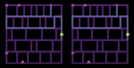

In [279]:
# sample = torch.randn(bs, 1024)
# compare_x = vae.decoder(sample)

# fixed_x, _ = next(iter(dataloader))
# fixed_x = fixed_x[:8]
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
#fixed_x = dataset[0][0].unsqueeze(0)
x, recon_x, code_z = compare(fixed_x)
print(code_z)
save_image(torch.cat([x, recon_x]).data.cpu(), './saved_images/'+ game + '/input_recon_image_' + vae_type + '.png')
display(Image('./saved_images/'+ game  + '/input_recon_image_' + vae_type + '.png', width=300, unconfined=True))

In [280]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    

# Load Data for Training VAE
test_dataset = ImageFolderWithPaths(root='./torch_images_label/' + game, transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), 
]))

In [281]:
# dataloader without shuffle for testing
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=bs)

def get_frame_id(path_tuple):
    frame_id_list = []
    for path in path_tuple:
        frame_id_list.append(int(path.split('_')[-1][:-4]))
    return torch.as_tensor(frame_id_list)

In [282]:
z_list = []
label_list = []
frame_list = []
for idx, (images, labels, path) in enumerate(test_dataloader):
        z_batch, _, _ = model.encode(images)
        z_list.append(z_batch)
        label_list.append(labels)
        frame_list.append(get_frame_id(path))
        z_all = torch.cat(z_list, dim=0)
        label_all = torch.cat(label_list, dim=0)
        frame_all = torch.cat(frame_list, dim=0)


In [283]:
from sklearn.decomposition import PCA
import pandas as pd
import umap

In [284]:
# Add label colunm to df
def add_colunm_to_df(df, columname, add_data, add_name):
    add_df = pd.DataFrame(list(add_data.detach().numpy()))
    df = pd.concat([df,add_df],axis = 1,join='inner', ignore_index=True)
    df = df.loc[:,~df.columns.duplicated()]
    columname.append(add_name)
    df.columns = columname
    return df 

In [285]:
z_all_np = z_all.detach().numpy()
if reduce_model == "umap": 
    reducer = umap.UMAP(n_components=num_component, n_neighbors= n_neighbors, min_dist = min_dist, random_state=42)
    embedding = reducer.fit_transform(z_all_np)
elif reduce_model == "tsne":
    reducer = TSNE(n_components=num_component, random_state = 42, perplexity = 30, n_iter = 1000)
    embedding = reducer.fit_transform(z_all_np)
elif reduce_model == "none":
    reducer = umap.UMAP(n_components=num_component, n_neighbors= n_neighbors, min_dist = min_dist, random_state=42)
    embedding = reducer.fit_transform(z_all_np)
    #embedding = z_all_np
    #num_component = 32

columname = ['component'+ str(i+1) for i in range(num_component)]
principalDf = pd.DataFrame(data = embedding[:,0:num_component], columns = columname)
principalDf = add_colunm_to_df(principalDf, columname, label_all, "label")
principalDf = add_colunm_to_df(principalDf, columname, frame_all, "frame")

columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
z_df =pd.DataFrame(data = z_all_np, columns = columname)
z_df = add_colunm_to_df(z_df, columname, label_all, "label")
z_df = add_colunm_to_df(z_df, columname, frame_all, "frame")

# Add label colunm to df

#label = pd.DataFrame(list(label_all.detach().numpy()))
#principalDf = pd.concat([principalDf,label],axis = 1,join='inner', ignore_index=True)
#principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
#columname.append("label")
#principalDf.columns = columname 

# Add frame colunm to df
#frame = pd.DataFrame(list(frame_all.detach().numpy()))
#principalDf = pd.concat([principalDf,frame],axis = 1,join='inner', ignore_index=True)
#principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
#columname.append("frame")
#principalDf.columns = columname 

<Figure size 640x480 with 0 Axes>

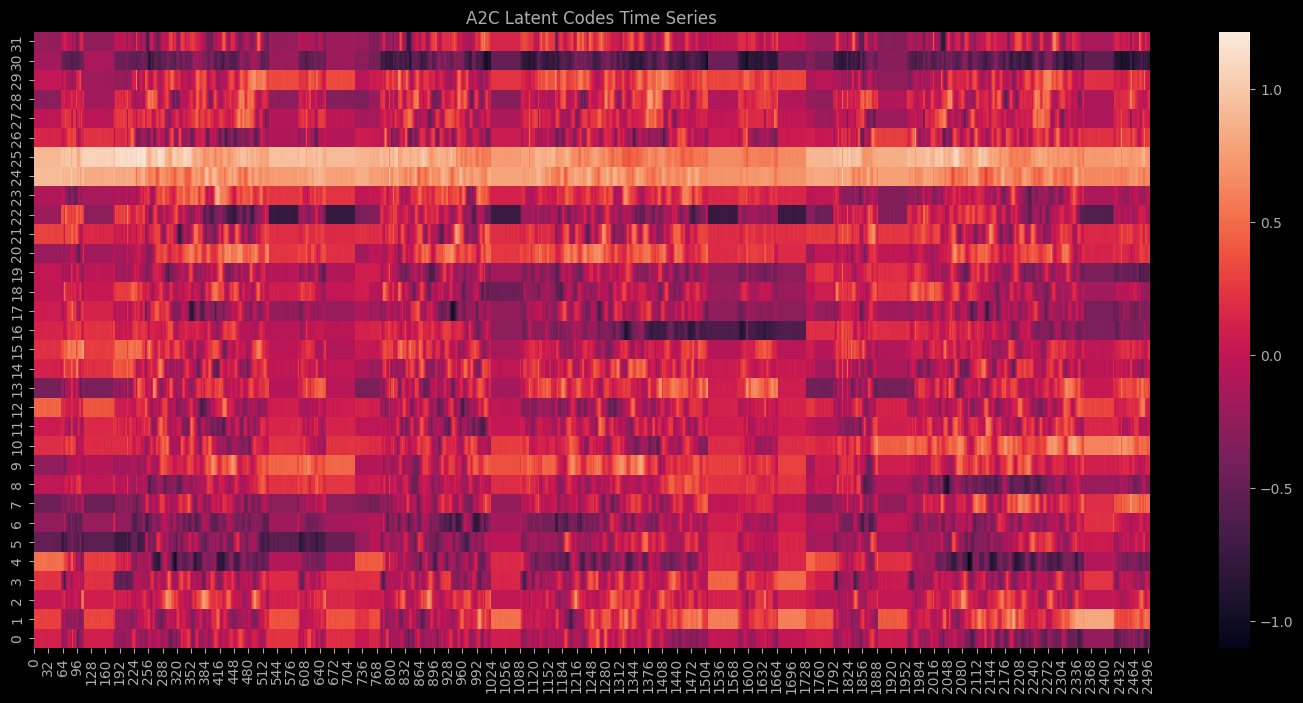

<Figure size 640x480 with 0 Axes>

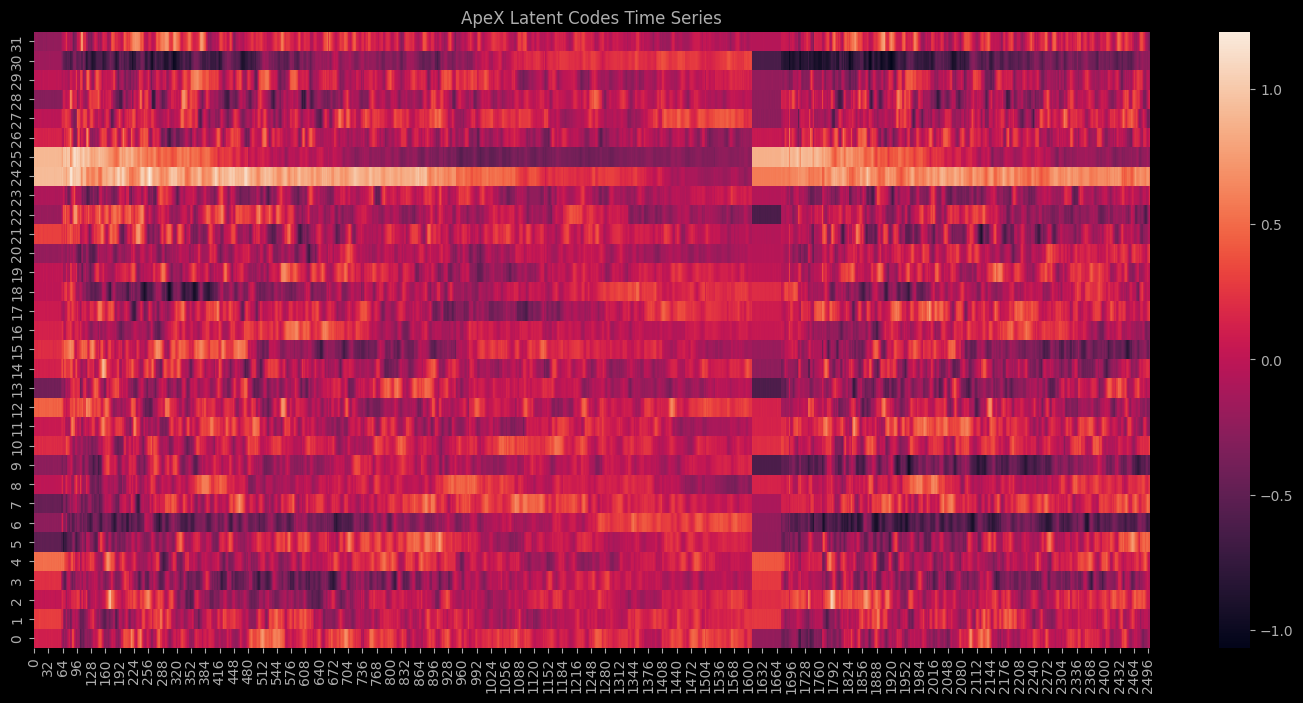

<Figure size 640x480 with 0 Axes>

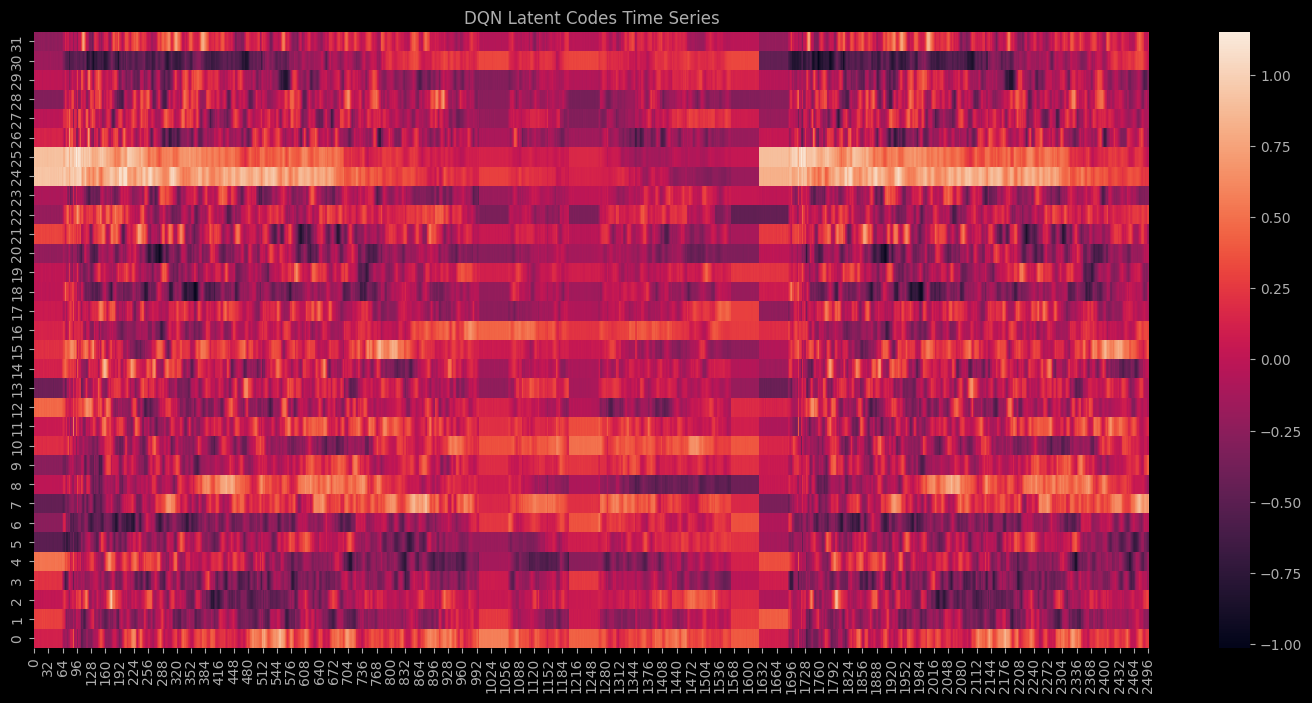

<Figure size 640x480 with 0 Axes>

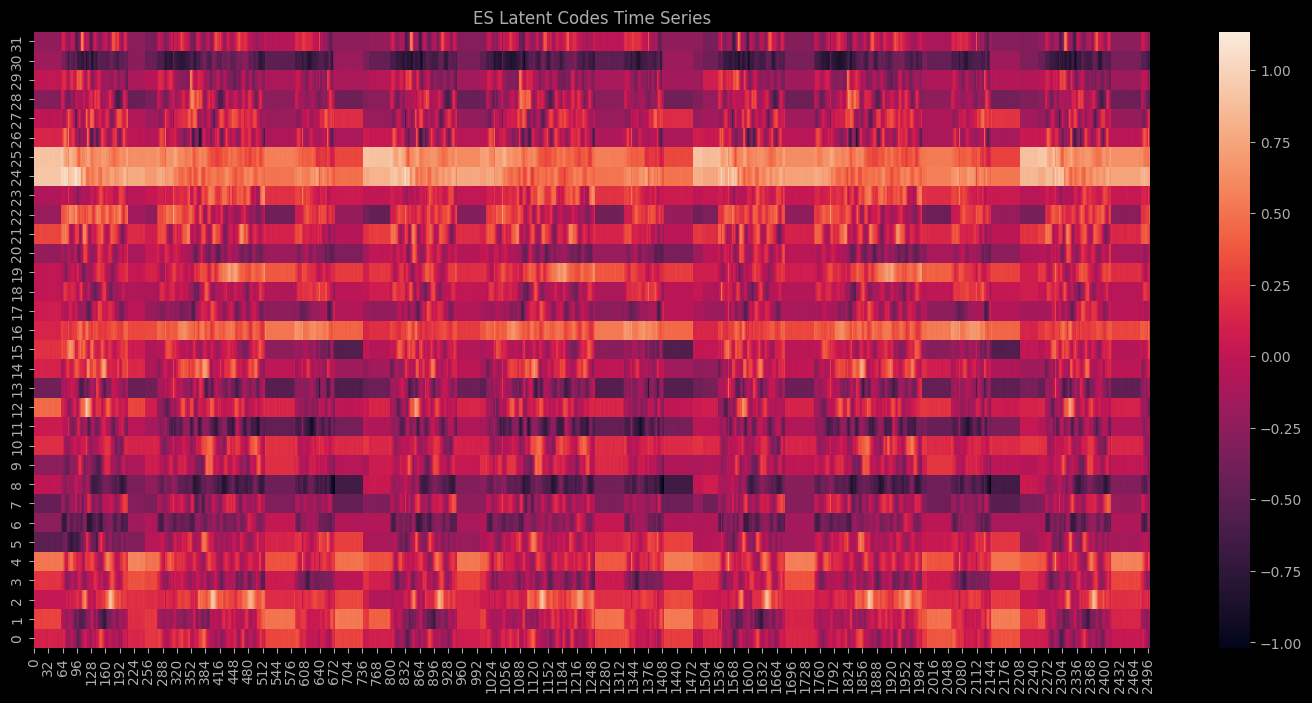

<Figure size 640x480 with 0 Axes>

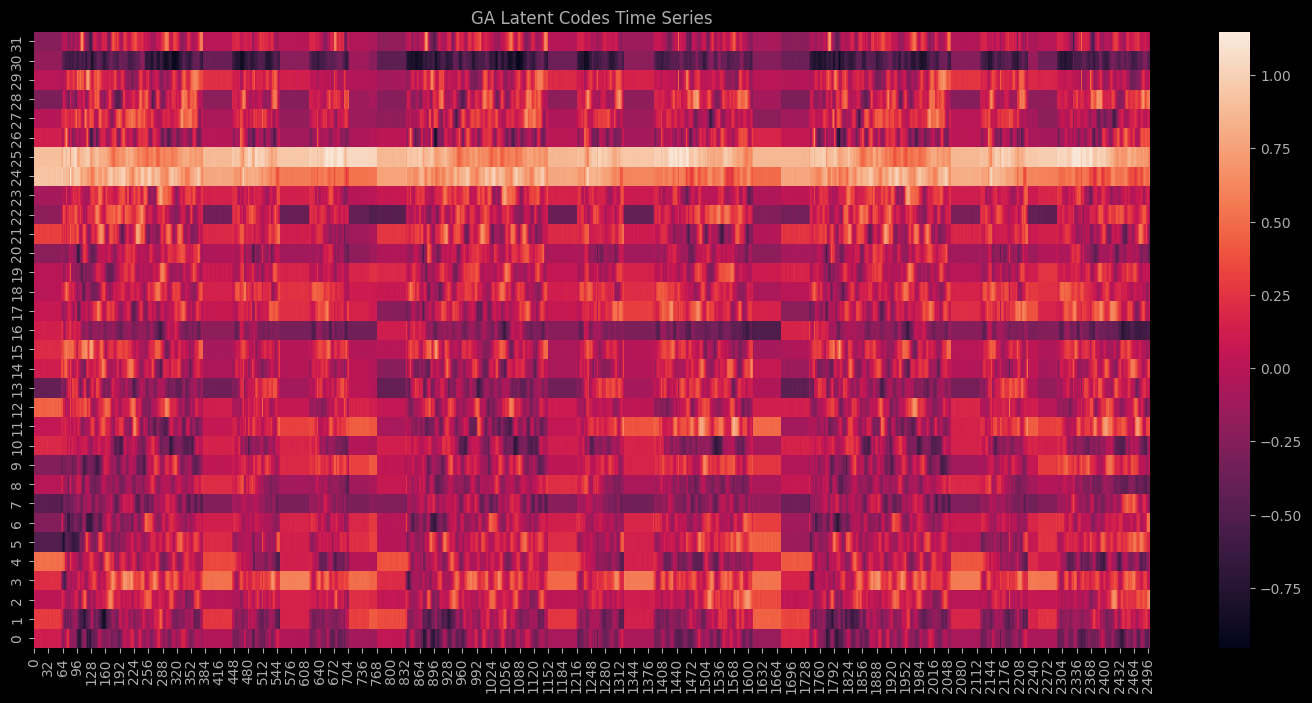

<Figure size 640x480 with 0 Axes>

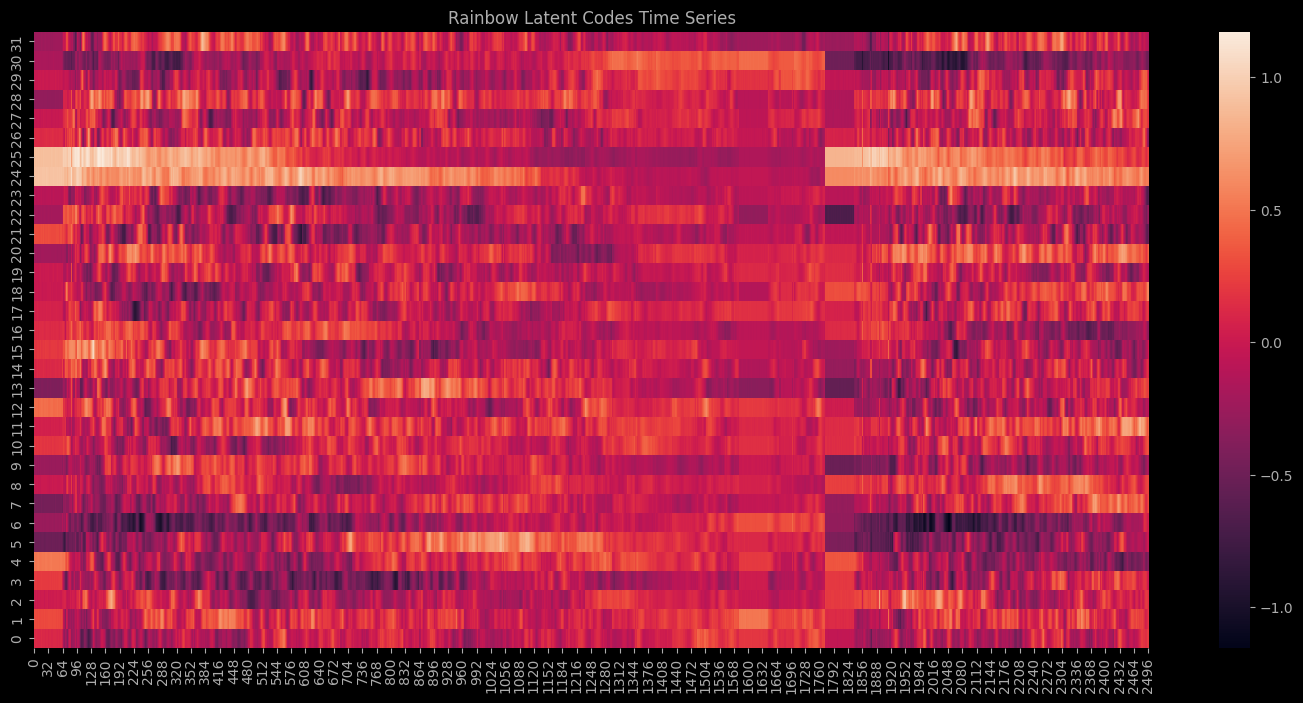

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]

for idx in range(len(label_name)):
    plt.figure(facecolor='#000000')
    fig, ax =plt.subplots(figsize=(18,8))
    df_by_agent_idx = z_df.loc[:,'label'] == idx
    df_by_agent = z_df[df_by_agent_idx]
    df_by_agent = df_by_agent.sort_values(by=['frame'])
    g=sns.heatmap(np.transpose(df_by_agent[columname].to_numpy()))
    cbar = g.collections[0].colorbar
    cbar.ax.tick_params(labelcolor='#adadad', color='#adadad')
    #ratio=0.2
    ax.set_xlim(0, 2500)  
    ax.set_ylim(0, 32)  
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim() 
    #ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
    fig.set_facecolor('#000000')
    ax.set_facecolor('#000000')
    ax.tick_params(colors='#adadad')
    ax.xaxis.label.set_color('#adadad')
    ax.yaxis.label.set_color('#adadad')
    ax.set_title(label_name[idx] + ' Latent Codes Time Series', color='#adadad')
    plt.show()

In [287]:
#import umap.plot
#umap.plot.connectivity(reducer, edge_bundling='hammer')

For DBSCAN Tuning 

<Figure size 640x480 with 0 Axes>

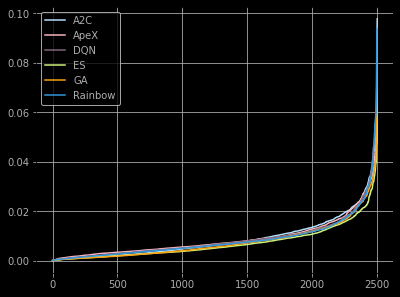

In [288]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
columname = ['component'+ str(i+1) for i in range(num_component)]

plt.figure(facecolor='#000000')
fig, ax =plt.subplots(dpi=72)
for idx in range(len(label_name)):
    df_by_agent_idx = z_df.loc[:,'label'] == idx
    df_by_agent = z_df[df_by_agent_idx]
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df_by_agent[columname])
    distances, indices = nbrs.kneighbors(df_by_agent[columname])
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances, label=idx, color=colors[idx])
plt.grid()
fig.set_facecolor('#000000')
ax.set_facecolor('#000000')
plt.legend(label_name, facecolor='#000000', labelcolor='#adadad')
ax.tick_params(colors='#adadad')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

In [289]:
import math
math.log(len(dataset.imgs)/len(label_name))

7.824112675300835

<Figure size 640x480 with 0 Axes>

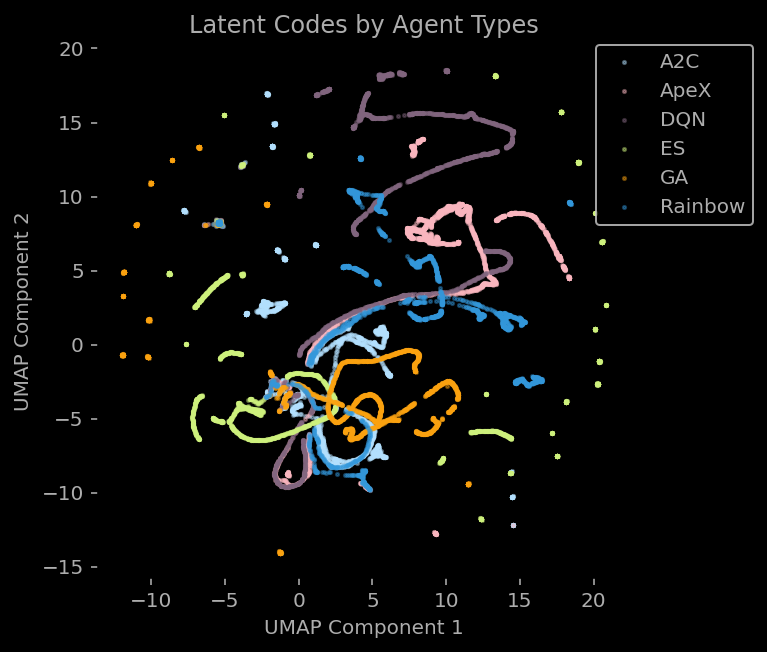

In [290]:
magnify = 2
plt.figure(facecolor='#000000')
fig, ax =plt.subplots(dpi=72*magnify)
label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

for idx, color in enumerate(colors):
    filter = principalDf["label"] == idx
    plotdata=principalDf.where(filter)
    ax.scatter(x=plotdata["component1"], y=plotdata["component2"], c=color, label=label_name[idx], alpha=0.4, marker='.',  s = 10)
    
ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.25,1.02))
fig.set_facecolor('#000000')
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title('Latent Codes by Agent Types', color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentAgent_' + vae_type + '.png')


In [291]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
import hdbscan
from st_dbscan import ST_DBSCAN
pd.options.mode.chained_assignment = None

cls = pd.DataFrame(np.nan, index=z_df.index, columns=['cls'])
columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
columname.append("label")
columname.append("frame")
#cls = pd.DataFrame(clus_result)
z_df = pd.concat([z_df,cls],axis = 1,join='inner', ignore_index=True)
z_df = z_df.loc[:,~z_df.columns.duplicated()]
#columname = z_df.columns
columname.append("cls")
z_df.columns = columname


if clustering == 'hir':
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        hir_clus_model = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward').fit(df_by_agent[columname].to_numpy())
        z_df["cls"].iloc[z_df["label"] == idx] = num_clusters*idx + hir_clus_model.labels_
        print(set(hir_clus_model.labels_))
    #hir_clus_model = AgglomerativeClustering(n_clusters = num_clusters, affinity = 'euclidean', linkage = 'ward')
    #principalDf["cls"] = hir_clus_model.fit_predict(z_all_np)

elif clustering == 'sc':
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        sc = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', eigen_solver="arpack").fit(df_by_agent[columname].to_numpy())
        z_df["cls"].iloc[z_df["label"] == idx] = num_clusters*idx + sc.labels_
        #print(set(sc.labels_))
        #sc = SpectralClustering(n_clusters=num_clusters).fit(z_all_np)
        #sc = SpectralClustering(n_clusters=num_clusters).fit(embedding[:,0:2])
        #principalDf["cls"] = sc.labels_

elif clustering == 'hdb':
    num_clusters_by_agent = []
    offset = 0
    for idx in range(len(colors)):
        df_by_agent_idx = z_df.loc[:,'label'] == idx
        df_by_agent = z_df[df_by_agent_idx]
        columname = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
        clusterer = hdbscan.HDBSCAN(min_cluster_size=cluser_size).fit(df_by_agent[columname].to_numpy())
        num_clusters = len(set(clusterer.labels_))
        print(set(clusterer.labels_+ 1))
        num_clusters_by_agent.append(num_clusters)
        if idx == 0:
            z_df["cls"].iloc[z_df["label"] == idx] = (clusterer.labels_ + 1)
            offset = num_clusters_by_agent[idx]
        else:
            z_df["cls"].iloc[z_df["label"] == idx] = offset + (clusterer.labels_ + 1)
            offset += num_clusters_by_agent[idx]
            
elif clustering == 'stdb':
        num_clusters_by_agent = []
        offset = 0
        for idx in range(len(colors)):
            df_by_agent_idx = z_df.loc[:,'label'] == idx
            df_by_agent = z_df[df_by_agent_idx]
            columname = ['frame']
            component_name = ['component'+ str(i+1) for i in range(z_all_np.shape[1])]
            columname = columname + component_name
            st_data = df_by_agent.loc[:, columname].values
            # eps1 : space, eps 2: time, eps1 from kink of nearest neighbor plot, min sample is from log(samples) = 9.6 original paper
            # eps1 2D 0.05, 4D 0.15
            st_dbscan = ST_DBSCAN(eps1 = ep1[idx], eps2 = ep2, min_samples = min_samples).fit(st_data) 
            num_clusters = len(set(st_dbscan.labels))
            print(set(st_dbscan.labels + 1))
            num_clusters_by_agent.append(num_clusters)
            if idx == 0:
                z_df["cls"].iloc[z_df["label"] == idx] = (st_dbscan.labels + 1)
                offset = num_clusters_by_agent[idx]
            else:
                z_df["cls"].iloc[z_df["label"] == idx] = offset + (st_dbscan.labels + 1)
                offset += num_clusters_by_agent[idx]

z_df.head()

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


component1  component2  component3  component4  component5  component6  \
0    0.118053    0.302818    0.030461    0.218515    0.516286   -0.518130   
1    0.106035    0.286660    0.022628    0.204490    0.515751   -0.504696   
2    0.096406    0.292137    0.033389    0.216962    0.520466   -0.501504   
3   -0.389467   -0.275053   -0.022681    0.096063   -0.067510   -0.548311   
4   -0.010940    0.715360    0.144544   -0.564015   -0.457174   -0.207868   

   component7  component8  component9  component10  ...  component26  \
0   -0.261896   -0.462153    0.012001    -0.260870  ...     0.907186   
1   -0.268593   -0.458790   -0.007495    -0.263343  ...     0.907182   
2   -0.259377   -0.463797   -0.011387    -0.263799  ...     0.897009   
3   -0.471253   -0.239555    0.234579     0.017863  ...     0.811267   
4   -0.549918    0.100280    0.109379     0.193985  ...     0.650893   

   component27  component28  component29  component30  component31  \
0     0.138425    -0.026103    -0.297142     0.007070    -0.163332   
1     0.136576     0.001185    -0.304451     0.007291    -0.179457   
2     0.140972    -0.011363    -0.303908     0.006797    -0.160054   
3    -0.121879     0.137989     0.153696     0.143979    -0.558743   
4    -0.149108    -0.042756    -0.256314    -0.294504    -0.677191   

   component32  label  frame  cls  
0    -0.230920      0      0  1.0  
1    -0.222841      0      1  1.0  
2    -0.224136      0     10  1.0  
3    -0.200162      0    100  0.0  
4     0.300679      0   1000  0.0  

[5 rows x 35 columns]

In [292]:
cls = pd.DataFrame(list(z_df["cls"]))
columname = columname = ['component'+ str(i+1) for i in range(num_component)]
columname.append("label")
columname.append("frame")
columname.append("cls")
principalDf = pd.concat([principalDf,cls],axis = 1,join='inner', ignore_index=True)
principalDf = principalDf.loc[:,~principalDf.columns.duplicated()]
principalDf.columns = columname 
principalDf.head()

component1  component2  label  frame  cls
0   -5.402508    8.346104      0      0  1.0
1   -5.512535    8.136270      0      1  1.0
2   -5.281569    8.160516      0     10  1.0
3   -0.452867   -2.531915      0    100  0.0
4    2.037318    0.488847      0   1000  0.0

In [293]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255))

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

In [294]:
def get_agentID_count(num_clusters_by_agent, agent_id, count):
    count += 1
    if count-1 == num_clusters_by_agent[agent_id]:
        count = 1
        agent_id +=1
    else:
        pass
    return agent_id, count

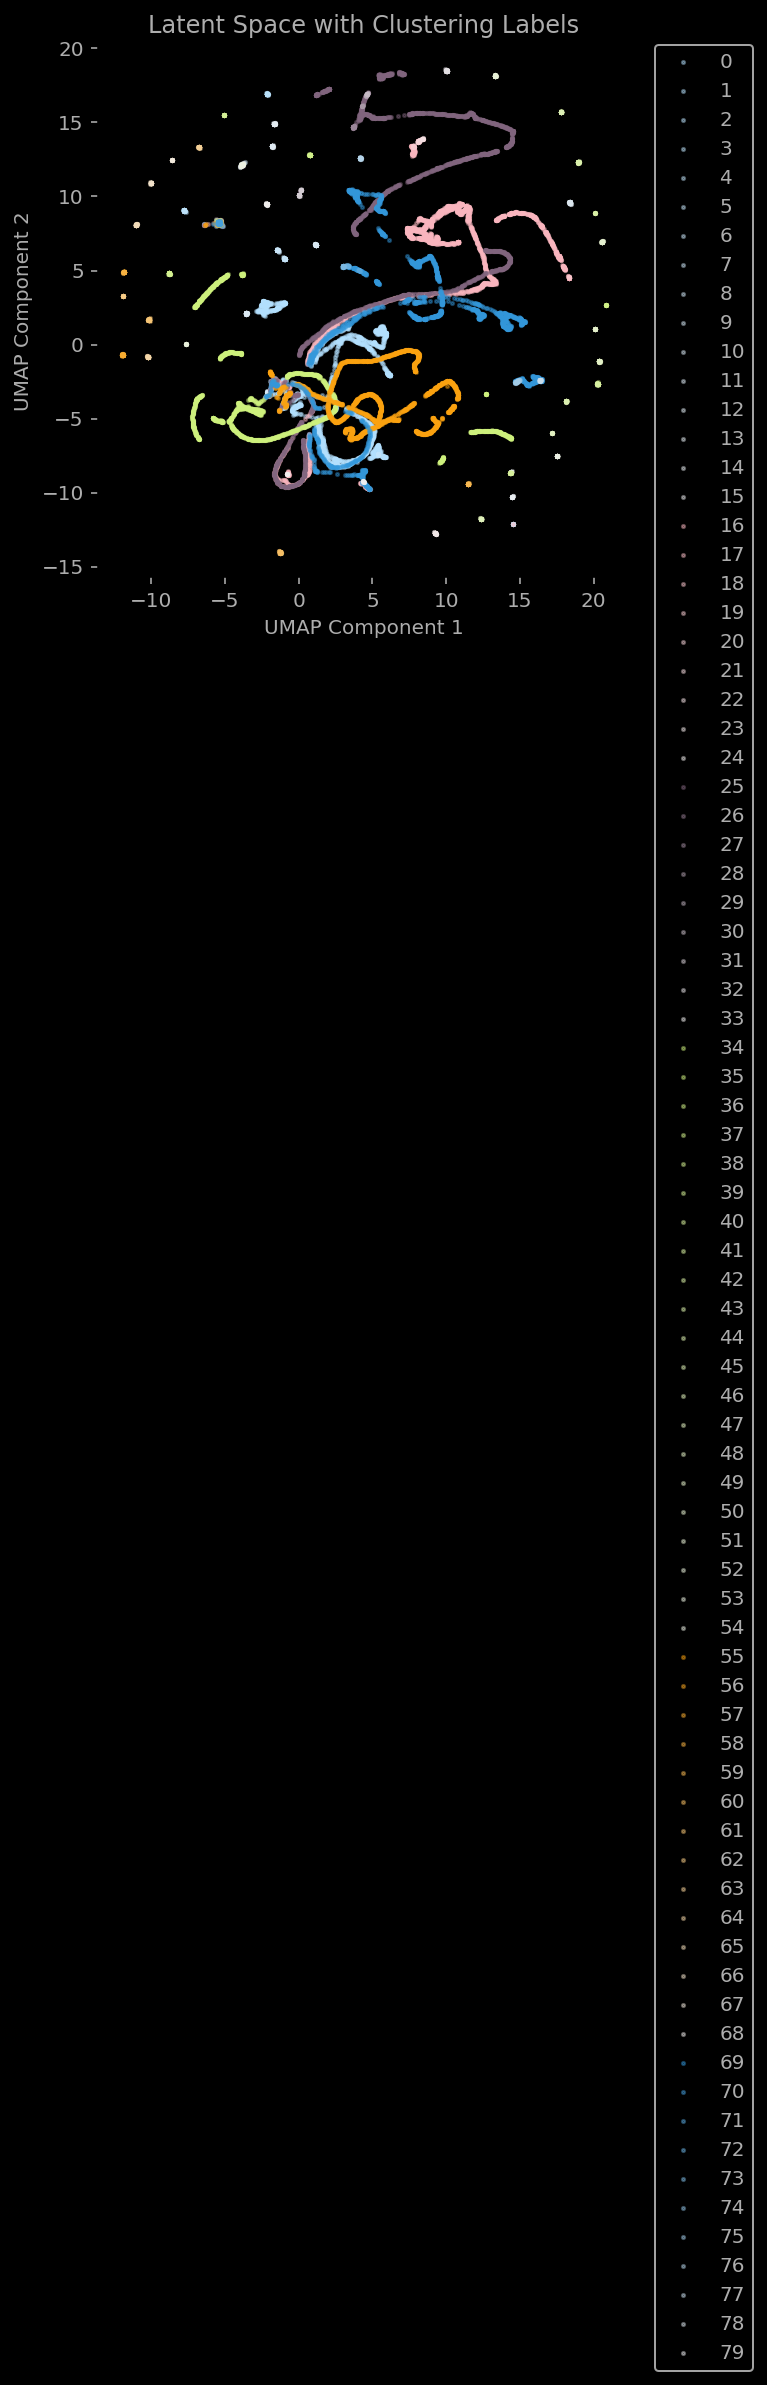

In [295]:

import seaborn as sns

magnify = 2
fig, ax =plt.subplots(dpi=72*magnify)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]   
count = 0 
agent_id = 0

#colors = sns.color_palette("husl", n_clusters)
agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
for i in range(n_clusters):
    filter = principalDf["cls"] == i 
    plotdata=principalDf.where(filter)

    if clustering == 'hdb' or clustering == 'stdb':   
        agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
        #print('agentID: ' + str(agent_id) + ', count: ' + str(count) + ', Color: ' + str(agent_colors[agent_id]))
        del colors
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
        #print(colors[count-1])
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[count-1]), label=i, marker='.', alpha=0.4, s = 10)
        
    else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        print('A agentID: ' + str(agent_id) + ', count: ' + str(i % num_clusters) + ', Color: ' + str(agent_colors[agent_id]))
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[i % num_clusters]), label=i, marker='.', alpha=0.4, s = 10)
       
fig.set_facecolor('#000000')
ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.25,1.02))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title('Latent Space with Clustering Labels', color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentClusters_' + vae_type + '.png')

In [296]:
z_code_by_cls_tensor = torch.empty(size=(n_clusters, z_all_np.shape[1]))

for i in range(n_clusters):
    filter = z_df["cls"] == i
    z_code_by_cls = z_df.where(filter)
    #z_code_by_cls_tensor[i] = torch.tensor(z_code_by_cls.mean()[:-1].values).float()
    z_code_by_cls_tensor[i] = torch.tensor(z_code_by_cls.median()[:-3].values).float()
    #print(z_code_by_cls_tensor[i])

    recon_image = model.decode(z_code_by_cls_tensor[i].reshape(1,-1))
    save_image(recon_image.data.cpu(), './cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png')
    #display(Image('./cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png', width=300, unconfined=True))

In [297]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
z_code_by_cls_np = z_code_by_cls_tensor.detach().numpy()
#z_cls_pca = pca.transform(z_code_by_cls_np)
z_cls_pca = reducer.transform(z_code_by_cls_np)

def getImage(path, zoom):
   return OffsetImage(plt.imread(path, format="png"), zoom=zoom)

def find_nearest(array, value):
   array = np.asarray(array)
   idx = (np.abs(array-value)).argmin()
   new_array = np.delete(array, idx)
   return array[idx], new_array

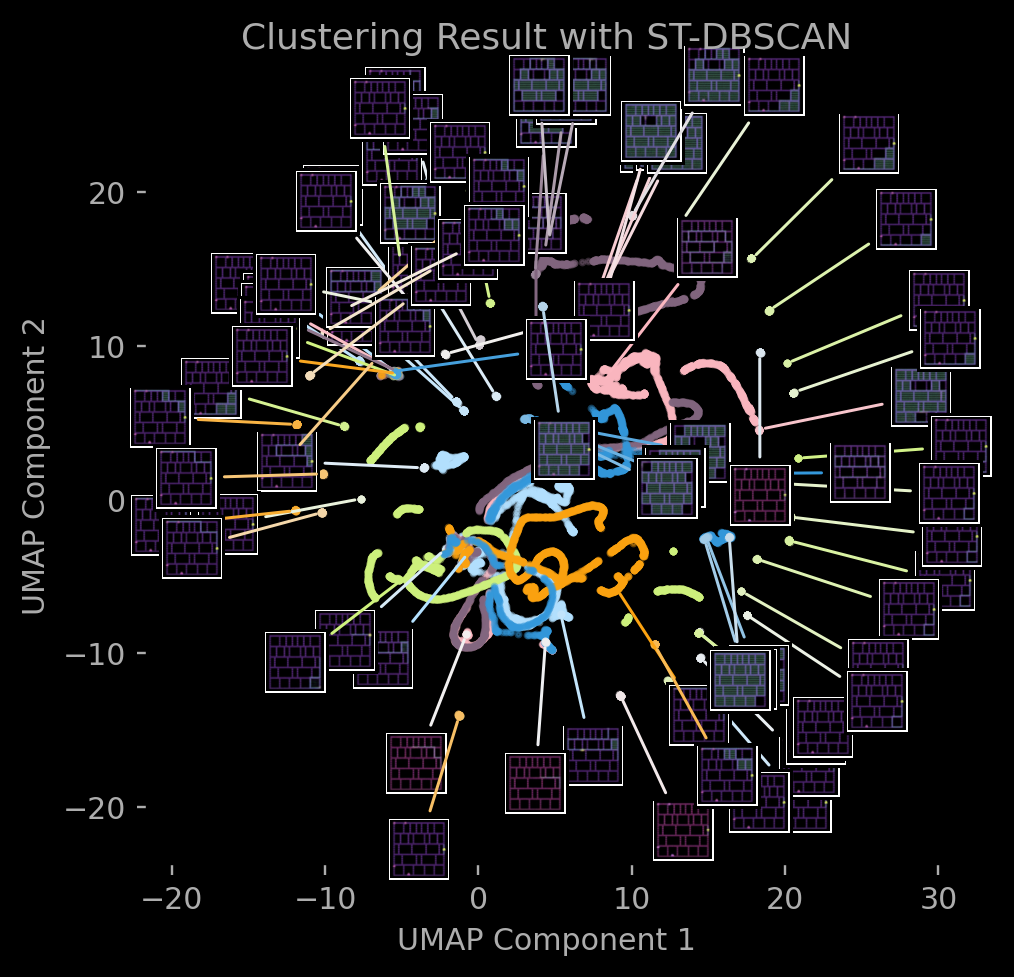

In [298]:
import math

magnify = 3
fig, ax =plt.subplots(dpi=72*magnify)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]    
count = 0 
agent_id = 0

#colors = sns.color_palette("husl", n_clusters)
agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

for i in range(n_clusters):
   filter = principalDf["cls"] == i
   plotdata=principalDf.where(filter)

   if clustering == 'hdb' or clustering == 'stdb':   
      agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
      #print('agentID: ' + str(agent_id) + ', count: ' + str(count))
      colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
      ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                  c=rgb_to_hex(colors[count-1]), label=i, marker='.', alpha=0.4, s = 10)
        
   else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        ax.scatter(x=plotdata["component1"], y=plotdata["component2"], 
                   c=rgb_to_hex(colors[i % num_clusters]), label=i, marker='.', alpha=0.4, s = 10)
        
   #agent_id = i // num_clusters
   #colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
   #ax.scatter(x=plotdata["component1"], y=plotdata["component2"], c=rgb_to_hex(colors[i % num_clusters]), marker='.', alpha=0.3, s = 2, label=str(i))

ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
if clustering == 'hdb': 
    title = 'Clustering Result with HDBSCAN'
elif clustering == 'sc': 
   title = 'Clustering Result with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Clustering Result with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Clustering Result with ST-DBSCAN'

ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
ratio = 1.0
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
xy_center = ((x_right+x_left)/2, (y_low+y_high)/2)
slot = np.linspace(-3.14, 3.14, num=n_clusters+10)
radius = 50
count = 0 
agent_id = 0

for i in range(n_clusters):
   path = './cls_images/' + game + '/cls_image_' + str(i) + '_' + clustering + '.png'
   xy = (z_cls_pca[i][0],  z_cls_pca[i][1])
   anot_rad = math.atan2(xy[1]-xy_center[1], xy[0]-xy_center[0])
   assigned_rad, slot = find_nearest(slot, anot_rad)
   
   if clustering == 'hdb' or clustering == 'stdb':   
      agent_id, count = get_agentID_count(num_clusters_by_agent, agent_id, count)
      #print('agentID: ' + str(agent_id) + ', count: ' + str(count))
      colors = sns.light_palette(agent_colors[agent_id],  num_clusters_by_agent[agent_id], reverse=True)
      ab = AnnotationBbox(getImage(path, zoom=0.3), xy, frameon=True,
                  xybox=(radius*math.cos(assigned_rad)+xy_center[0], radius*math.sin(assigned_rad)+xy_center[1]),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.1,
                  arrowprops=dict(arrowstyle="-", color=rgb_to_hex(colors[count-1]))
                  )
        
   else:  
        agent_id = i // num_clusters
        colors = sns.light_palette(agent_colors[agent_id],  num_clusters, reverse=True)
        ab = AnnotationBbox(getImage(path, zoom=0.3), xy, frameon=True,
                  xybox=(radius*math.cos(assigned_rad)+xy_center[0], radius*math.sin(assigned_rad)+xy_center[1]),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.1,
                  arrowprops=dict(arrowstyle="-", color=rgb_to_hex(colors[i % num_clusters]))
                  )
   

   ax.add_artist(ab)
fig.set_facecolor('#000000')
#ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.45,1.02))
offset=8
ax.set_xlim(x_left-offset, x_right+offset)  
ax.set_ylim(y_low-offset, y_high+offset)   
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

plt.savefig('./saved_images/' + game + '/LatentClusters_with_recon_images_' + clustering + '_' + vae_type + '.png')

In [299]:
def get_cls_sequence(agent_num, df, min_frame, max_frame):
    filter = df["label"] == int(agent_num)
    agent_data = df.where(filter).sort_values("frame")
    agent_data_np = np.asarray(agent_data["cls"][min_frame:max_frame])
    cls_seq = agent_data_np[~np.isnan(agent_data_np)]
    return cls_seq

# window analysis filtering
def get_most_frequent_cls(seq, window):
    max_cls_in_window = []
    for i in range(len(seq)- window + 1):
        lst = list(seq[i : i + window])
        max_cls_in_window.append(max(lst, key=lst.count))
    return np.array(max_cls_in_window).astype(int)


def get_minimum_sequence(seq):
    cls_diff_index = np.nonzero(np.diff(np.array(seq)))[0]
    return np.append(seq[cls_diff_index-1], seq[-1])



In [300]:
def transition_matrix(transitions, n):
    #n = 1+ max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:

#t = [1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
#m = transition_matrix(t)
#for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))

arrow, umap graph

In [301]:
min_frames = [0, 0, 0, 0, 0, 0]
max_frames = [698, 2499, 2499, 2499, 2499, 1475]
inference_frame_size = {
    "alien":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "amidar":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "assault":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "asterix":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "atrantis":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "battlezone":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "berzerk":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "bowling":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "boxing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "breakout":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [698, 2499, 2499, 2499, 2499, 1475]},
    "chopper":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "fishing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "freeway":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "icehockey":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "kungfumaster":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "montezuma":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "mspacman":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "pong":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "qbert":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "seaquest":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "skiing":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
    "spaceinveders":{"min_frames" : [0, 0, 0, 0, 0, 0], "max_frames" : [2499, 2499, 2499, 2499, 2499, 2499]},
}
min_frames = inference_frame_size[game]["min_frames"]
max_frames = inference_frame_size[game]["max_frames"]

Get Initial Image

In [302]:
initial_x = dataset[0][0].unsqueeze(0)
z_initial, _, _ = model.encode(initial_x)
initial_recon_image = model.decode(z_initial.reshape(1,-1))
z_initial_pca = reducer.transform(z_initial.detach().numpy())
save_image(initial_recon_image.data.cpu(), './cls_images/' + game + '/initial.png')

****** A2C ******
[ 1  3 12 13 14 15  2  5  6  7  8 10 11]
****** ApeX ******
[17 19 20 23]
****** DQN ******
[26 27 30 31 32 33]
****** ES ******
[35 44 49 50 51 53 54 37 38 39 40 41 43 45 46 48]
****** GA ******
[56 64 65 66 67 68 57 58 59 60 61 62 63]
****** Rainbow ******
[70 72 73 75 76 77 78]


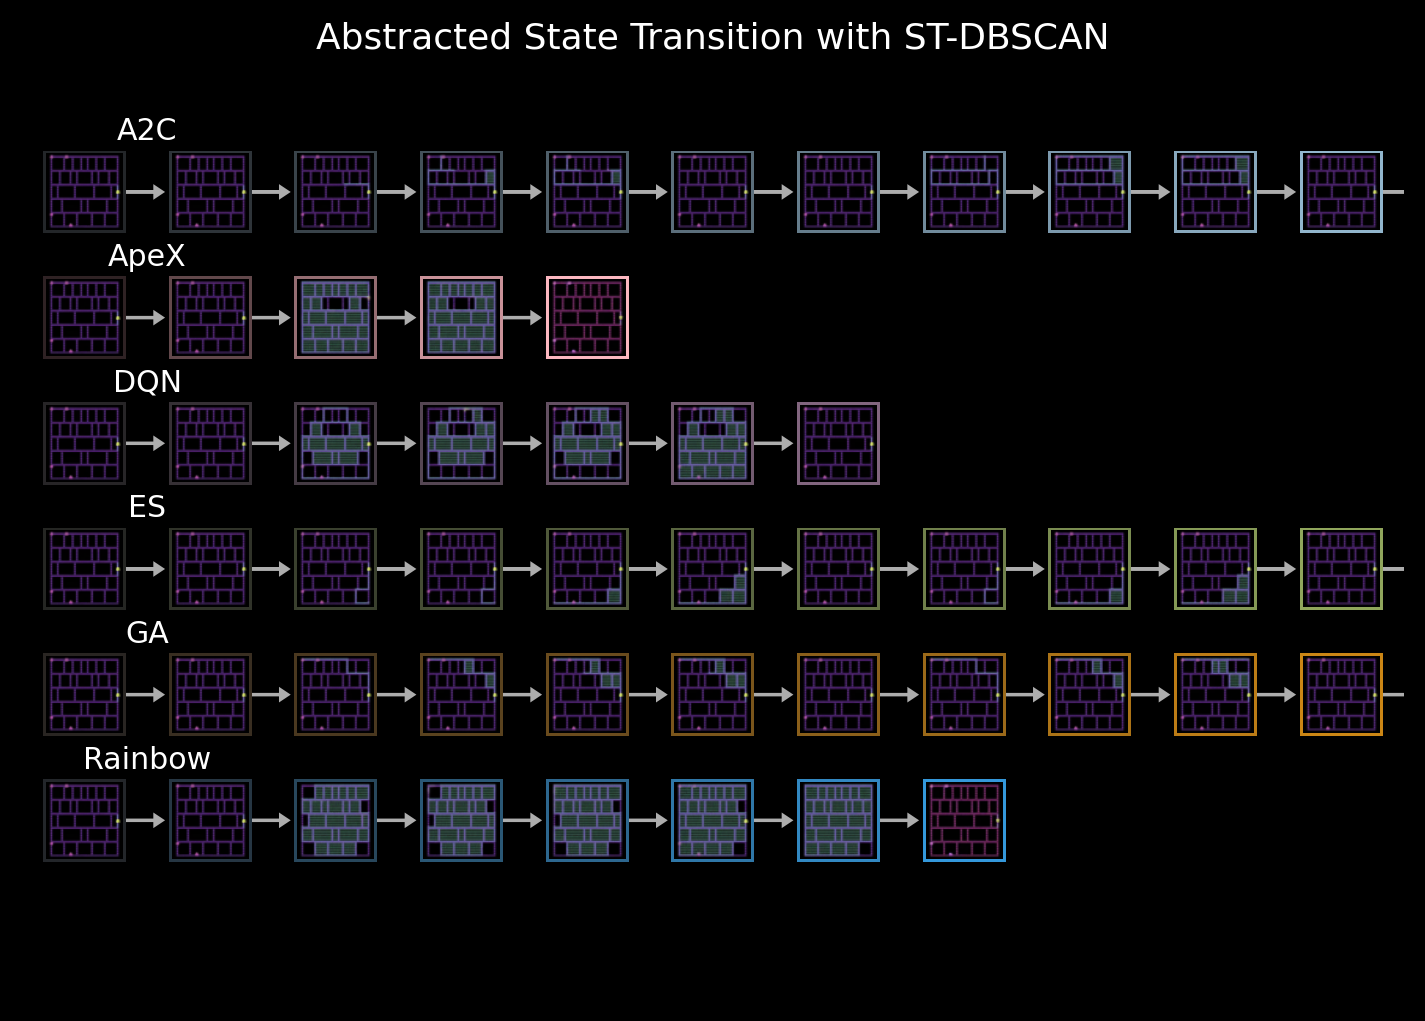

In [303]:
from matplotlib.offsetbox import TextArea

window_size = 50
magnify = 3
fig, ax =plt.subplots(dpi=72*magnify)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0] 

if clustering == 'hdb': 
    title = 'Abstracted State Transition with HDBSCAN'
elif clustering == 'sc': 
   title = 'Abstracted State Transition with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Abstracted State Transition with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Abstracted State Transition with ST-DBSCAN'

ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#FFFFFF')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')
matrix = []
colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
#min_frames = [0, 0, 0, 0, 0, 0]
#max_frames = [698, 2499, 2499, 2499, 2499, 1475]
for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)
   
   
   print('****** ' + label_name[i] + ' ******')
   #print(cls_seq)
   #print(max_cls_in_window)
   print(min_cls_seq)
   m = transition_matrix(min_cls_seq, n_clusters)
   #print(m)
   #for row in m: print(' '.join('{0:.2f}'.format(x) for x in row))
   matrix.append(m)
   offsetbox = TextArea(label_name[i], textprops=dict(color='#FFFFFF'))
   dx = 0
   dy = 0.12 - i*0.25
   xy = (dx,  dy)
   ab = AnnotationBbox(offsetbox, xy, frameon=False,
                    xybox=xy,
                    xycoords='data'                    
                    )
   ax.add_artist(ab)

   
   path = './cls_images/' + game + '/initial.png'
   dx = -0.25 
   dy = 0 - i*0.25
   xy = (dx,  dy)
   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
   ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=2))
   ax.add_artist(ab)
   ax.arrow(dx, dy, 0.28, 0, head_width = 0.02, head_length = 0.03, fc ='#adadad', ec ='#adadad')
   
   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      dx = -0.25 + (j+1)*0.5 
      dy = 0 - i*0.25
      xy = (dx,  dy)
      #colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)
      ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=2))
      ax.add_artist(ab)
      if cls != min_cls_seq[-1]:
         ax.arrow(dx, dy, 0.28, 0, head_width = 0.02, head_length = 0.03, fc ='#adadad', ec ='#adadad')
      
fig.set_facecolor('#000000')
ax.set_xlim(-0.5, 5)  
ax.set_ylim(-1.4, 0.25)  
ratio = 0.6
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.savefig('./saved_images/' + game + '/ClusterTransition_' + clustering + '_' + vae_type + '.png')


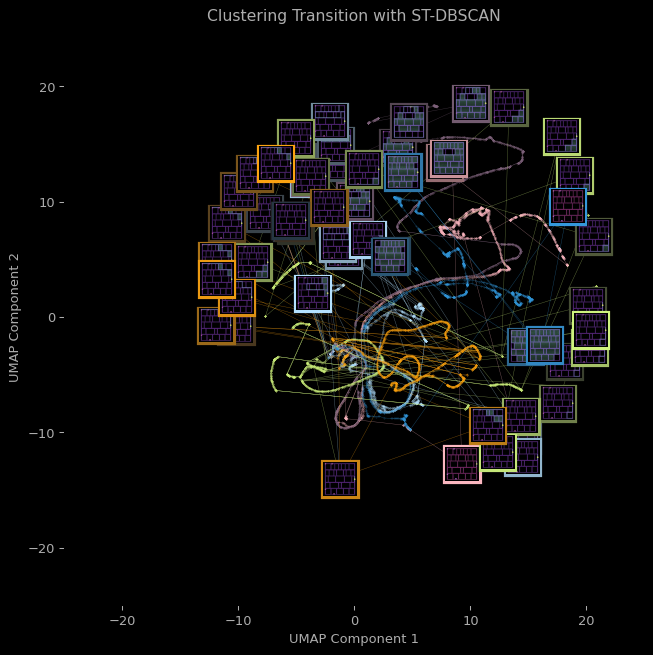

In [304]:
magnify = 1.3
fig, ax =plt.subplots(dpi=72*magnify, figsize=(8,8))
cluster_labels = np.unique(principalDf["cls"])  
n_clusters = cluster_labels.shape[0]    
count = 0 
agent_id = 0

agent_colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
if clustering == 'hdb': 
    title = 'Clustering Transition with HDBSCAN'
elif clustering == 'sc': 
   title = 'Clustering Transition with Spectral Clustering'
elif clustering == 'hir': 
   title = 'Clustering Transition with Agglomerative Clustering'
elif clustering == 'stdb': 
   title = 'Clustering Transition with ST-DBSCAN'

ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
for idx, color in enumerate(colors):
   filter = principalDf["label"] == idx
   plotdata=principalDf.where(filter).sort_values(by=['frame'])
   #ax.scatter(x=plotdata["component1"], y=plotdata["component2"],
   #   c=color, label=label_name[idx], alpha=0.1, marker='.',  s = 5)
   ax.plot(plotdata["component1"], plotdata["component2"],
      c=color, label=label_name[idx], alpha=0.5, marker='.', ls='-', linewidth=0.3, markersize=0.5)

for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)

   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)

   path = './cls_images/' + game + '/initial.png'
   xy = (z_initial_pca[0][0],  z_initial_pca[0][1])
   
   ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=4))
      

   ax.add_artist(ab)

   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      xy = (z_cls_pca[cls][0],  z_cls_pca[cls][1])
      
      ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=4))
         

      ax.add_artist(ab)
fig.set_facecolor('#000000')
#offset=20
#ratio=1
#ax.set_xlim(np.min(z_cls_pca[:][0])-offset, np.max(z_cls_pca[:][0])+offset)  
#ax.set_ylim(np.min(z_cls_pca[:][1])-offset, np.max(z_cls_pca[:][1])+offset)   
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25)   
#x_left, x_right = ax.get_xlim()
#y_low, y_high = ax.get_ylim()
#ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
#ax.legend(facecolor='#000000', labelcolor='#adadad', bbox_to_anchor=(1.45,1.02))

plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_' + clustering + '_' + vae_type + '.png')

Create Node and Edge data

In [305]:
from datashader.bundling import hammer_bundle

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
ds_nodes_py = []
ds_edges_py = []
for idx, color in enumerate(colors):
    filter = principalDf["label"] == idx
    sorted_data = principalDf.where(filter).sort_values(by=['frame'])
    sorted_data = sorted_data[~np.isnan(sorted_data['frame'])]
    prev_node = 0
    for ind in sorted_data.index:
        ds_nodes_py.append([ind, sorted_data['component1'][ind], sorted_data['component2'][ind], int(idx)]) 
        if int(sorted_data['frame'][ind]) != 0:
            ds_edges_py.append([prev_node, ind, int(idx)])
            
        prev_node = ind

ds_nodes = pd.DataFrame(ds_nodes_py, columns=['name', 'x', 'y', 'label'])      
ds_edges = pd.DataFrame(ds_edges_py, columns=['source', 'target', 'label'])



#nx.draw_networkx_nodes(graph, pos=pos, node_color=c_iris[nodes], ax=ax, node_size=50, edgecolors='white', linewidths=1)
#nx.draw_networkx_edges(graph, pos=pos, width=weights, alpha=0.1618, ax=ax)
    #ax.plot(plotdata["component1"], plotdata["component2"],
    #  c=color, label=label_name[idx], alpha=0.5, marker='.', ls='-', linewidth=0.3, markersize=0.5)

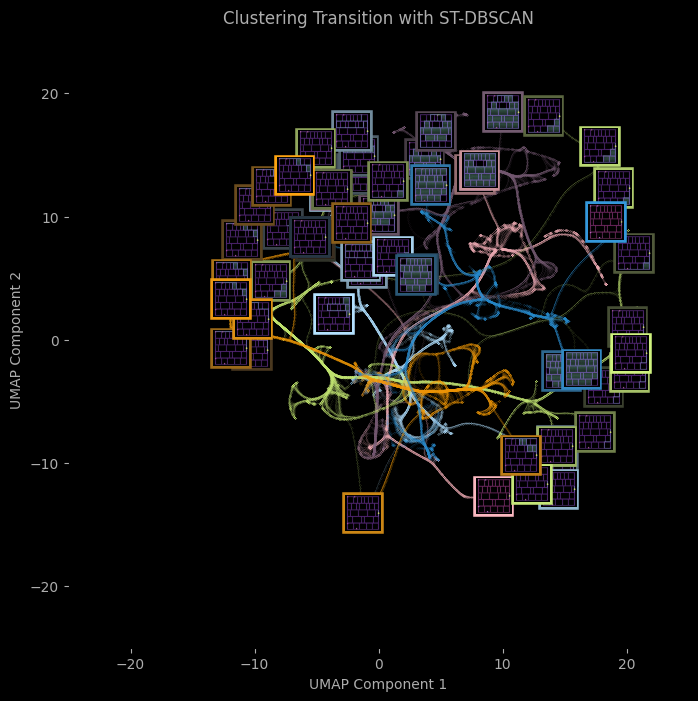

In [306]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#adadad')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')


for idx, color in enumerate(colors):
    filter = ds_edges["label"] == idx
    ds_edges_label = ds_edges.where(filter)[['source', 'target']]
    ds_edges_label = ds_edges_label[~np.isnan(ds_edges_label['source'])]
    filter = ds_nodes["label"] == idx
    ds_nodes_label = ds_nodes.where(filter)[['name', 'x', 'y']]
    ds_nodes_label = ds_nodes_label[~np.isnan(ds_nodes_label['x'])]
    #print(ds_nodes_label)
    #print(ds_edges_label)
    hb = hammer_bundle(ds_nodes_label, ds_edges_label, iterations=5, decay=0.5, initial_bandwidth=1.0)
    ax.plot(hb.x, hb.y, c=color, zorder=1, alpha=0.4, marker='.', ls='-', linewidth=0.1, markersize=0.2)


data_clustered = []
node_id = 0
for i in range(len(label_name)):
   min_frame = min_frames[i]
   max_frame = max_frames[i]
   cls_seq = get_cls_sequence(agent_num=i, df=principalDf, min_frame=min_frame, max_frame=max_frame)
   if clustering == 'stdb' or clustering == 'hdb':
      noise_index = np.where(cls_seq == np.min(cls_seq))[0]
      if noise_index.size == cls_seq.size: # if all are the noise, keep the cluster
         noise_index = []
      cls_seq = np.delete(cls_seq,  noise_index)
   max_cls_in_window = get_most_frequent_cls(cls_seq, window_size)
   min_cls_seq = get_minimum_sequence(max_cls_in_window)

   colors = sns.dark_palette(agent_colors[i],  len(min_cls_seq)+1, reverse=False)

   path = './cls_images/' + game + '/initial.png'
   xy = (z_initial_pca[0][0],  z_initial_pca[0][1])
   data_clustered.append([z_initial_pca[0][0],  z_initial_pca[0][1], path, -1, -1, -1]) # x, y, path, agent id, node_id, source
   ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                  xybox=(0, 0),
                  xycoords='data',
                  boxcoords="offset points",
                  pad=0.0,
                  bboxprops =dict(edgecolor=colors[0], lw=4))
      

   ax.add_artist(ab)

   for j, cls in enumerate(min_cls_seq):
      path = './cls_images/' + game + '/cls_image_' + str(cls) + '_' + clustering + '.png'
      xy = (z_cls_pca[cls][0],  z_cls_pca[cls][1])

      # Create Graph Object
      if j==0:
         data_clustered.append([z_cls_pca[cls][0],  z_cls_pca[cls][1], path, i, node_id, -1]) # x, y, path, agent id, node_id, source
      else:
         data_clustered.append([z_cls_pca[cls][0],  z_cls_pca[cls][1], path, i, node_id, prev_node])

      prev_node=node_id
      node_id += 1
         
      ab = AnnotationBbox(getImage(path, zoom=0.4), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=colors[j+1], lw=4))
         

      ax.add_artist(ab)

df_clustered = pd.DataFrame(data_clustered, columns=['x', 'y', 'path', 'agent id', 'node_id', 'source']) 

fig.set_facecolor('#000000')
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25) 
plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_bundle_' + clustering + '_' + vae_type + '.png')

In [307]:
column_name=list(df_clustered.columns) + ['high_cls']

hir_clus_model = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'ward').fit(df_clustered[['x','y']].to_numpy())
cls = pd.DataFrame(list(hir_clus_model.labels_))

df_clustered = pd.concat([df_clustered,cls],axis = 1,join='inner', ignore_index=True)
df_clustered = df_clustered.loc[:,~df_clustered.columns.duplicated()]
df_clustered.columns = column_name
df_clustered.head(20)

x          y                                       path  agent id  \
0   -5.542602   8.343687            ./cls_images/amidar/initial.png        -1   
1   -5.384083   8.236109   ./cls_images/amidar/cls_image_1_stdb.png         0   
2   -7.721547   9.008910   ./cls_images/amidar/cls_image_3_stdb.png         0   
3   -1.740128  13.442986  ./cls_images/amidar/cls_image_12_stdb.png         0   
4   -1.629285  14.905470  ./cls_images/amidar/cls_image_13_stdb.png         0   
5   14.476664 -10.267257  ./cls_images/amidar/cls_image_14_stdb.png         0   
6   14.400315  -8.609704  ./cls_images/amidar/cls_image_15_stdb.png         0   
7   -2.148970  16.946213   ./cls_images/amidar/cls_image_2_stdb.png         0   
8   -0.934456   5.772881   ./cls_images/amidar/cls_image_5_stdb.png         0   
9   -1.448351   6.401439   ./cls_images/amidar/cls_image_6_stdb.png         0   
10  14.507056 -12.141614   ./cls_images/amidar/cls_image_7_stdb.png         0   
11  -3.913520  12.066490   ./cls_images/amidar/cls_image_8_stdb.png         0   
12   1.147769   6.745383  ./cls_images/amidar/cls_image_10_stdb.png         0   
13  -3.581924   2.071903  ./cls_images/amidar/cls_image_11_stdb.png         0   
14  -5.542602   8.343687            ./cls_images/amidar/initial.png        -1   
15  -5.346481   8.336697  ./cls_images/amidar/cls_image_17_stdb.png         1   
16   7.776667  13.394076  ./cls_images/amidar/cls_image_19_stdb.png         1   
17   8.130530  13.738458  ./cls_images/amidar/cls_image_20_stdb.png         1   
18   9.270612 -12.742205  ./cls_images/amidar/cls_image_23_stdb.png         1   
19  -5.542602   8.343687            ./cls_images/amidar/initial.png        -1   

    node_id  source  high_cls  
0        -1      -1         0  
1         0      -1         0  
2         1       0         0  
3         2       1         1  
4         3       2         1  
5         4       3         2  
6         5       4         2  
7         6       5         1  
8         7       6         6  
9         8       7         6  
10        9       8         2  
11       10       9         1  
12       11      10         6  
13       12      11         6  
14       -1      -1         0  
15       13      -1         0  
16       14      13         8  
17       15      14         8  
18       16      15         2  
19       -1      -1         0

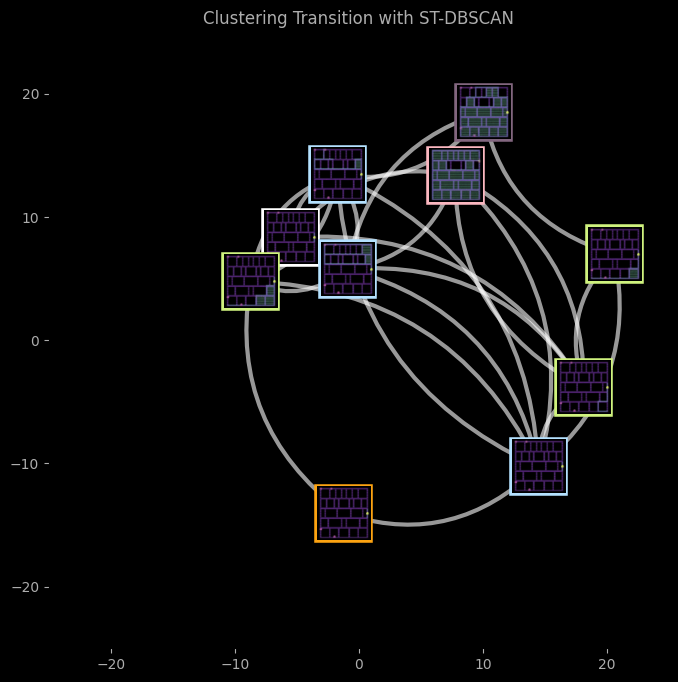

In [308]:
import networkx as nx

G = nx.DiGraph()
cluster_labels = np.unique(df_clustered["high_cls"]) 
for h_cls in cluster_labels:
    pos_x = list(df_clustered[df_clustered["high_cls"]==h_cls]['x'])
    pos_y = list(df_clustered[df_clustered["high_cls"]==h_cls]['y'])
    path = list(df_clustered[df_clustered["high_cls"]==h_cls]['path'])
    agent_id = list(df_clustered[df_clustered["high_cls"]==h_cls]['agent id'])
    G.add_node(h_cls, pos=(pos_x[0], pos_y[0]), path=path[0], agent_id = agent_id[0])
    #print(list(df_clustered[df_clustered["high_cls"]==h_cls]['source']))
    for source in list(df_clustered[df_clustered["high_cls"]==h_cls]['source']):
        #print(source)
        for source_cls in list(df_clustered[df_clustered["node_id"] == source]['high_cls']):
            #print('source: ' + str(source_cls)+ ' target: '+ str(h_cls))
            if source_cls != h_cls: G.add_edge(source_cls, h_cls)

colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]
fig, ax = plt.subplots(figsize=(8,8))
ax.set_facecolor('#000000')
ax.tick_params(colors='#adadad')
ax.set_title(title, color='#adadad')
ax.xaxis.label.set_color('#adadad')
ax.yaxis.label.set_color('#adadad')

pos = nx.get_node_attributes(G, 'pos')
path = nx.get_node_attributes(G, 'path')
agent_id = nx.get_node_attributes(G, 'agent_id')

for edge in G.edges():
    source, target = edge
    rad = -0.3
    
    arrowprops=dict(arrowstyle="->", 
                    color='w',
                    connectionstyle=f"arc3,rad={rad}",
                    linestyle= '-',
                    alpha=0.6,
                    linewidth=3,
                    )
    ax.annotate("",
                xy=pos[target],
                xytext=pos[source],
                arrowprops=arrowprops,
               )
    



for i, p in path.items():
    xy=pos[i]
    if agent_id[i]==-1:
        edgecolor='w'
    else:
        edgecolor=colors[agent_id[i]]
    ab = AnnotationBbox(getImage(p, zoom=0.6), xy, frameon=True,
                     xybox=(0, 0),
                     xycoords='data',
                     boxcoords="offset points",
                     pad=0.0,
                     bboxprops =dict(edgecolor=edgecolor, lw=4))
         

    ax.add_artist(ab)

#nx.draw_networkx_nodes(G,pos)

fig.set_facecolor('#000000')
ax.set_xlim(-25, 25)  
ax.set_ylim(-25, 25) 
    #print(df_clustered[df_clustered["node_id"] == df_clustered[df_clustered["high_cls"]==h_cls]['source']]["high_cls"])
#G.add_node(id,pos=(x,y))
plt.savefig('./saved_images/' + game + '/ClusterTransition_in_latent_simple_' + clustering + '_' + vae_type + '.png')


In [315]:
corners = np.array([
    [-25, 25],  # upper left
    [25, 25],  # upper right
    [-25, -25],  # lower left
    [25, -25],  # lower right
])
num_point = 40
test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, num_point)
    for x in np.linspace(0, 1, num_point)
])


In [316]:
inv_transformed_z = reducer.inverse_transform(test_pts)

<Figure size 640x480 with 0 Axes>

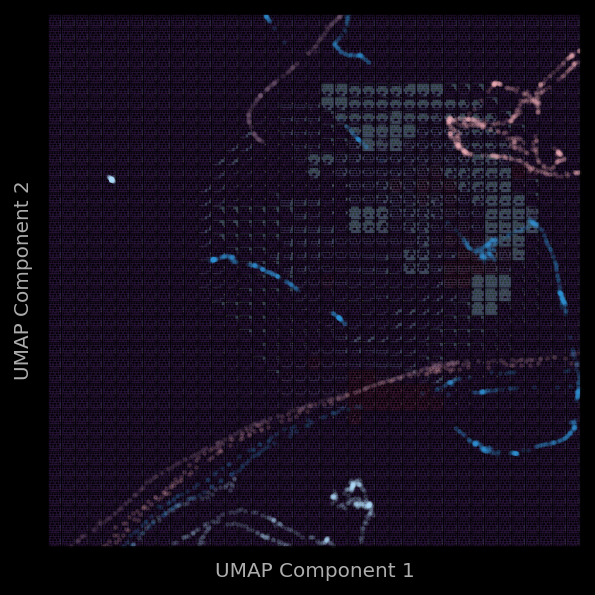

In [327]:

def plot_latent_space(model, n=num_point):
    magnify = 2
    plt.figure(facecolor='#000000')
    fig, ax =plt.subplots(dpi=72*magnify)
    label_name = ['A2C','ApeX','DQN','ES','GA','Rainbow']
    colors = ['#B4E1FF','#FBB7C0','#82667F','#CFF27E', "#FCA311", "#3498db"]

    for idx, color in enumerate(colors):
        filter = principalDf["label"] == idx
        plotdata=principalDf.where(filter)
        ax.scatter(x=plotdata["component1"]*64*4, y=plotdata["component2"]*64*4,
                   c=color, label=label_name[idx], alpha=0.1, marker='.',  s = 10)
        
        
    # display a n*n 2D manifold of digits
    digit_size_x = 64
    digit_size_y = 64
    figure = np.zeros((digit_size_x * n, digit_size_y * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(0, 25, n)
    grid_y = np.linspace(0, 25, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            index = i*n + j
            recon_x = model.decode(torch.tensor([inv_transformed_z[index]]))
            save_image(recon_x.data.cpu(), './saved_images/'+ game +'/input_recon_image_' + vae_type + '_latent.png')
            digit = plt.imread('./saved_images/'+ game +'/input_recon_image_' + vae_type + '_latent.png')
            #digit = recon_x[0].reshape(digit_size_x, digit_size_y, 3).to('cpu').detach().numpy()
            figure[
                (n-i-1) * digit_size_x : (n-i-1+1) * digit_size_x,
                j * digit_size_y : (j + 1) * digit_size_y,
                0:3
            ] = digit
    #fig, ax = plt.subplots(dpi=72*magnify, figsize=(5,5))
    fig.set_facecolor('#000000')
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.xaxis.label.set_color('#adadad')
    ax.yaxis.label.set_color('#adadad') 
    ax.set_xlim(0, 2500)  
    ax.set_ylim(0, 2500) 
    plt.imshow(figure, alpha=1)
    #plt.show()


plot_latent_space(model)

In [312]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

class Node():

    def __init__(
        self, center, radius, label,
        facecolor='#2653de', edgecolor='#e6e6e6',
        ring_facecolor='#a3a3a3', ring_edgecolor='#a3a3a3',
        **kwargs
        ):
        """
        Initializes a Markov Chain Node(for drawing purposes)
        Inputs:
            - center : Node (x,y) center
            - radius : Node radius
            - label  : Node label
        """
        self.center = center
        self.radius = radius
        self.label  = label

        # For convinience: x, y coordinates of the center
        self.x = center[0]
        self.y = center[1]

        # Drawing config
        self.node_facecolor = facecolor
        self.node_edgecolor = edgecolor

        self.ring_facecolor = ring_facecolor
        self.ring_edgecolor = ring_edgecolor
        self.ring_width = 0.03

        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': kwargs.get("node_fontsize", 12)
        }


    def add_circle(self, ax):
        """
        Add the annotated circle for the node
        """
        circle = mpatches.Circle(self.center, self.radius)
        p = PatchCollection(
            [circle],
            edgecolor = self.node_edgecolor,
            facecolor = self.node_facecolor
        )
        ax.add_collection(p)
        ax.annotate(
            self.label,
            xy = self.center,
            color = '#ffffff',
            **self.text_args
        )


    def add_self_loop(self, ax, prob=None, direction='up', annotate = True, percentages = False):
        """
        Draws a self loop
        """
        if direction == 'up':
            start = -30
            angle = 180
            ring_x = self.x
            ring_y = self.y + self.radius
            prob_y = self.y + 1.3*self.radius
            x_cent = ring_x - self.radius + (self.ring_width/2)
            y_cent = ring_y - 0.15
        else:
            start = -210
            angle = 0
            ring_x = self.x
            ring_y = self.y - self.radius
            prob_y = self.y - 1.4*self.radius
            x_cent = ring_x + self.radius - (self.ring_width/2)
            y_cent = ring_y + 0.15

        # Add the ring
        ring = mpatches.Wedge(
            (ring_x, ring_y),
            self.radius,
            start,
            angle,
            width = self.ring_width
        )
        # Add the triangle (arrow)
        offset = 0.2
        left   = [x_cent - offset, ring_y]
        right  = [x_cent + offset, ring_y]
        bottom = [(left[0]+right[0])/2., y_cent]
        arrow  = plt.Polygon([left, right, bottom, left])

        p = PatchCollection(
            [ring, arrow],
            edgecolor = self.ring_edgecolor,
            facecolor = self.ring_facecolor
        )
        ax.add_collection(p)

        # Probability to add?
        if prob and annotate:
            text = f"{prob*100 if percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if percentages else ""
            ax.annotate(text, xy=(self.x, prob_y), color='#000000', **self.text_args)

In [313]:
# module from this repository
#from node import Node
class MarkovChain:

    def __init__(self, M, labels, **kwargs):
        """
        Initializes a Markov Chain (for drawing purposes)
        Inputs:
            - M         Transition Matrix
            - labels    State Labels
            - kwargs    Keywords to modify how data is displayed, specifically:
                        annotate          if False, probabilities aren't shown
                        arrow_edgecolor
                        arrow_facecolor
                        arrow_head_width
                        arrow_width
                        fontsize          affects transition probability labels
                        node_edgecolor
                        node_facecolor
                        node_fontsize     affects node labels
                        node_radius
                        percentages       bool, if True probabilites should be
                                          displayed as percentages instead of decimals
                        transparency_func function to determine transparency of arrows (default: alpha = prob)
        """

        np.set_printoptions(precision=3,suppress=True)



        if M.shape[0] < 2:
            raise Exception("There should be at least 2 states")
        if M.shape[0] != M.shape[1]:
            raise Exception("Transition matrix should be square")
        if M.shape[0] != len(labels):
            raise Exception("There should be as many labels as states")

        # save args
        self.M = M
        self.n_states = M.shape[0]
        self.labels = labels

        self.save_kwargs(**kwargs)



        # Build the network
        self.build_network()

    def save_kwargs(self, **kwargs):

        # save the dictionary
        self.kwargs = kwargs

        # Colors
        self.arrow_facecolor = self.kwargs.get("arrow_facecolor", '#a3a3a3')
        self.arrow_edgecolor = self.kwargs.get("arrow_edgecolor", '#a3a3a3')
        self.node_facecolor = self.kwargs.get("node_facecolor", '#2693de')
        self.node_edgecolor = self.kwargs.get("node_edgecolor", '#e6e6e6')

        # Drawing config
        self.node_radius = self.kwargs.get("node_radius", 0.60)
        self.arrow_width = self.kwargs.get("arrow_width", 0.1)
        self.arrow_head_width = self.kwargs.get("arrow_head_width", 0.22)
        self.text_args = {
            'ha': 'center',
            'va': 'center',
            'fontsize': self.kwargs.get("fontsize", 14)
        }

        # How to represent the probabilities
        self.percentages = self.kwargs.get("percentages", False)
        self.annotate_probabilities = self.kwargs.get("annotate", True)
        self.transparency_func = self.kwargs.get("transparency_func", lambda p: p)


    def set_node_centers(self):
        """
            Spread the nodes evenly around in a circle using Euler's formula
            e^(2pi*i*k/n), where n is the number of nodes and k is the
            index over which we iterate. The real part is the x coordinate,
            the imaginary part is the y coordinate. Then scale by n for more room.

            self.node_centers is a numpy array of shape (n,2)
        """

        # For legibility, we use n below
        n = self.n_states

        # generate the evenly spaced coords on the unit circle
        unit_circle_coords = np.fromfunction(lambda x,y:
                        (1-y)*np.real(np.exp(2 * np.pi * x/n * 1j))
                        + y * np.imag(np.exp(2 * np.pi * x/n * 1j)),
                        (n,2))
        factor=0.3
        self.figsize = ((n*2+2)*factor, (n*2+2)*factor)
        self.xlim = (-n-1, n+1)
        self.ylim = (-n-1, n+1)

        # Scale by n to have more room
        self.node_centers = unit_circle_coords * n


    def build_network(self):
        """
        Loops through the matrix, add the nodes
        """
        # Position the node centers
        self.set_node_centers()

        # Set the nodes
        self.nodes = [Node(self.node_centers[i],
                           self.node_radius,
                           self.labels[i],
                           **self.kwargs) for i in range(self.n_states)]


    def add_arrow(self, ax,
                  node1, node2,
                  prob=None, width=None,
                  head_width=None,
                  annotate = True,
                  arrow_spacing = 0.15,
                  transparency_func = None):
        """
        Add a directed arrow between two nodes

        Keywords:

        annotate:                if True, probability is displayed on top of the arrow
        arrow_spacing:           determines space between arrows in opposite directions
        head_width:              width of arrow head
        prob:                    probability of going from node1 to node2
        transparency_func:       function to determine transparency of arrows
        width:                   width of arrow body
        """


        if width is None:
            width = self.arrow_width
        if head_width is None:
            head_width = self.arrow_head_width
        if transparency_func is None:
            transparency_func = self.transparency_func

        # x,y start of the arrow, just touching the starting node
        x_start = node1.x + node1.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        y_start = node1.y + node1.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)

        # find the arrow length so it just touches the ending node
        dx = node2.x-x_start - node2.radius*(node2.x-node1.x)/np.linalg.norm(node2.center-node1.center)
        dy = node2.y-y_start - node2.radius*(node2.y-node1.y)/np.linalg.norm(node2.center-node1.center)


        # calculate offset so arrows in opposite directions are separate

        x_offset = dy / np.sqrt(dx**2+dy**2) * arrow_spacing
        y_offset = -dx / np.sqrt(dx**2+dy**2) * arrow_spacing

        arrow = mpatches.FancyArrow(
            x_start + x_offset,
            y_start + y_offset,
            dx,
            dy,
            width = width,
            head_width = head_width,
            length_includes_head = True
        )
        p = PatchCollection(
            [arrow],
            edgecolor = self.arrow_edgecolor,
            facecolor = self.arrow_facecolor,
            alpha = transparency_func(prob)
        )
        ax.add_collection(p)

        # Add label of probability at coordinates (x_prob, y_prob)
        x_prob = x_start +  0.2*dx + 1.2 * x_offset
        y_prob = y_start +  0.2*dy + 1.2 * y_offset
        if prob and annotate:
            text = f"{prob*100 if self.percentages else prob:.1f}".rstrip("0").rstrip(".")
            text += "%" if self.percentages else ""
            ax.annotate(text, xy=(x_prob, y_prob), color='#000000', **self.text_args)


    def draw(self, name='', img_path=None):
        """
        Draw the Markov Chain
        """
        fig, ax = plt.subplots(figsize=self.figsize)
        ax.set_title(name)
        # Set the axis limits
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)

        # Draw the nodes
        for node in self.nodes:
            node.add_circle(ax)

        # Add the transitions
        for i in range(self.M.shape[0]):
            for j in range(self.M.shape[1]):
                # self loops
                if i == j and self.M[i,i] > 0:
                    self.nodes[i].add_self_loop(ax,
                                                prob = self.M[i,j],
                                                direction = 'up' if self.nodes[i].y >= 0 else 'down',
                                                annotate = self.annotate_probabilities,
                                                percentages = self.percentages)

                # directed arrows
                elif self.M[i,j] > 0:
                    self.add_arrow(ax,
                                   self.nodes[i],
                                   self.nodes[j],
                                   prob = self.M[i,j],
                                   annotate = self.annotate_probabilities)

        plt.axis('off')
        # Save the image to disk?
        if img_path:
            plt.savefig(img_path)
        plt.show()

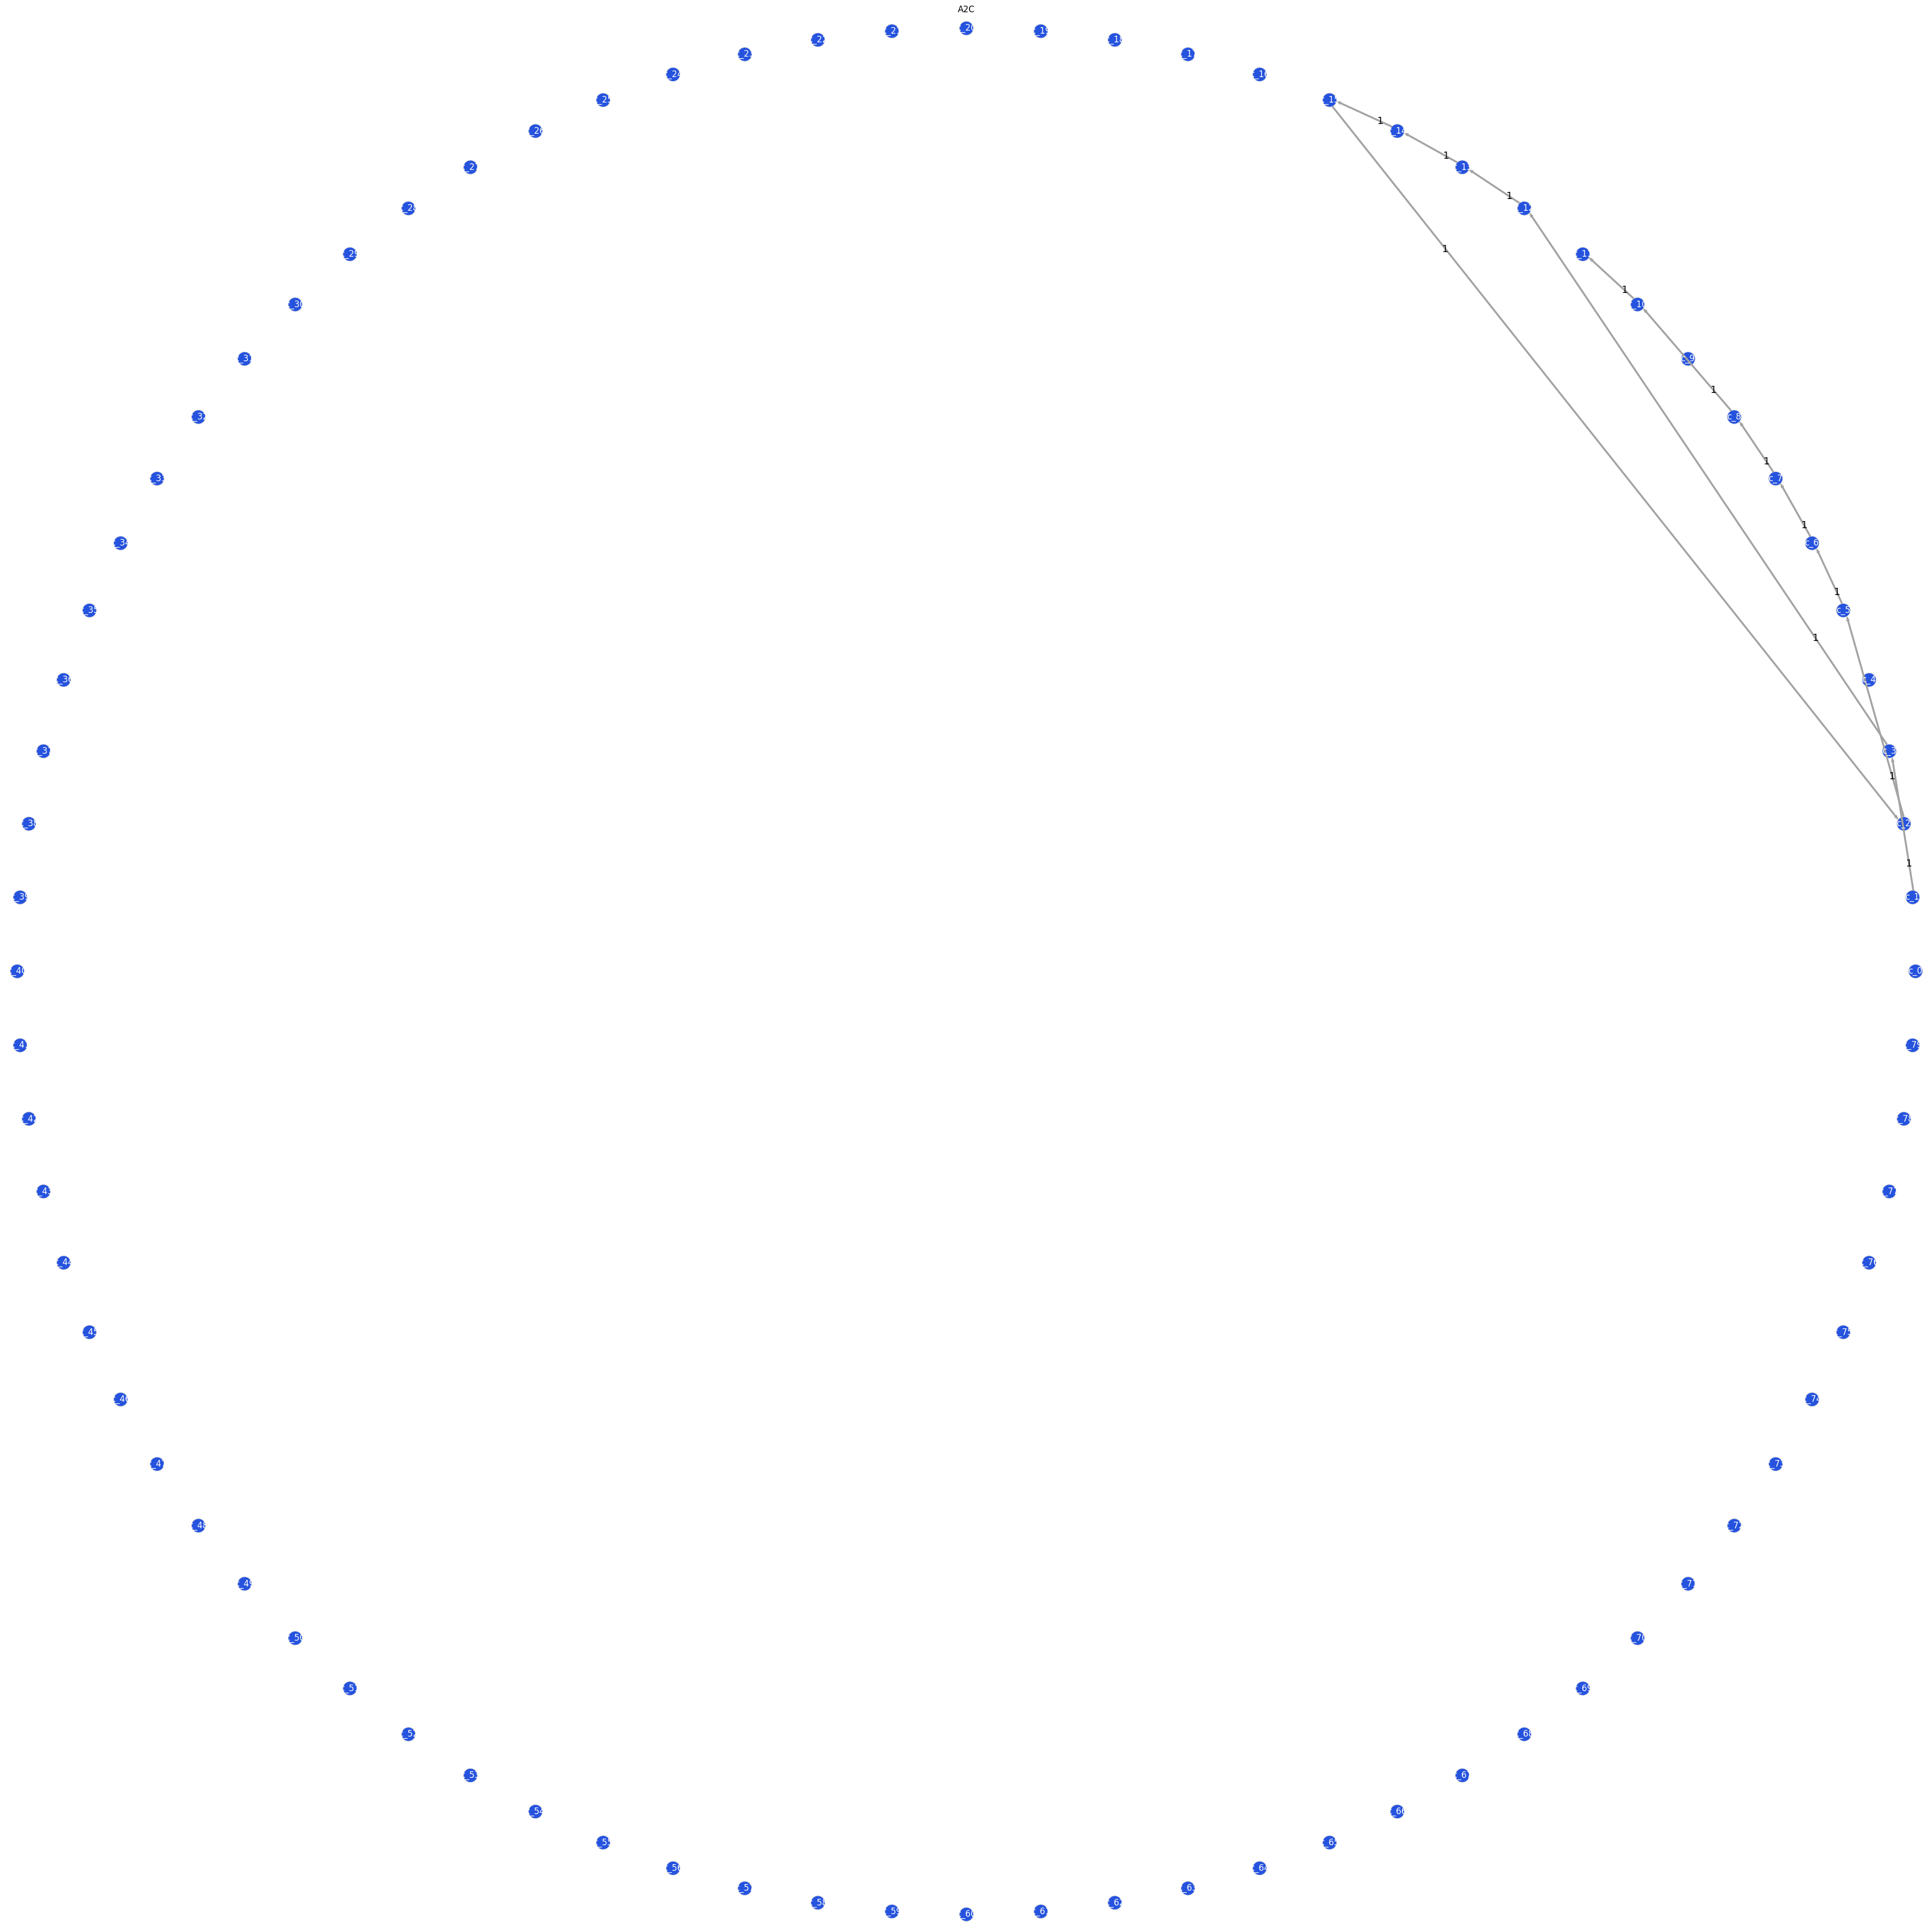

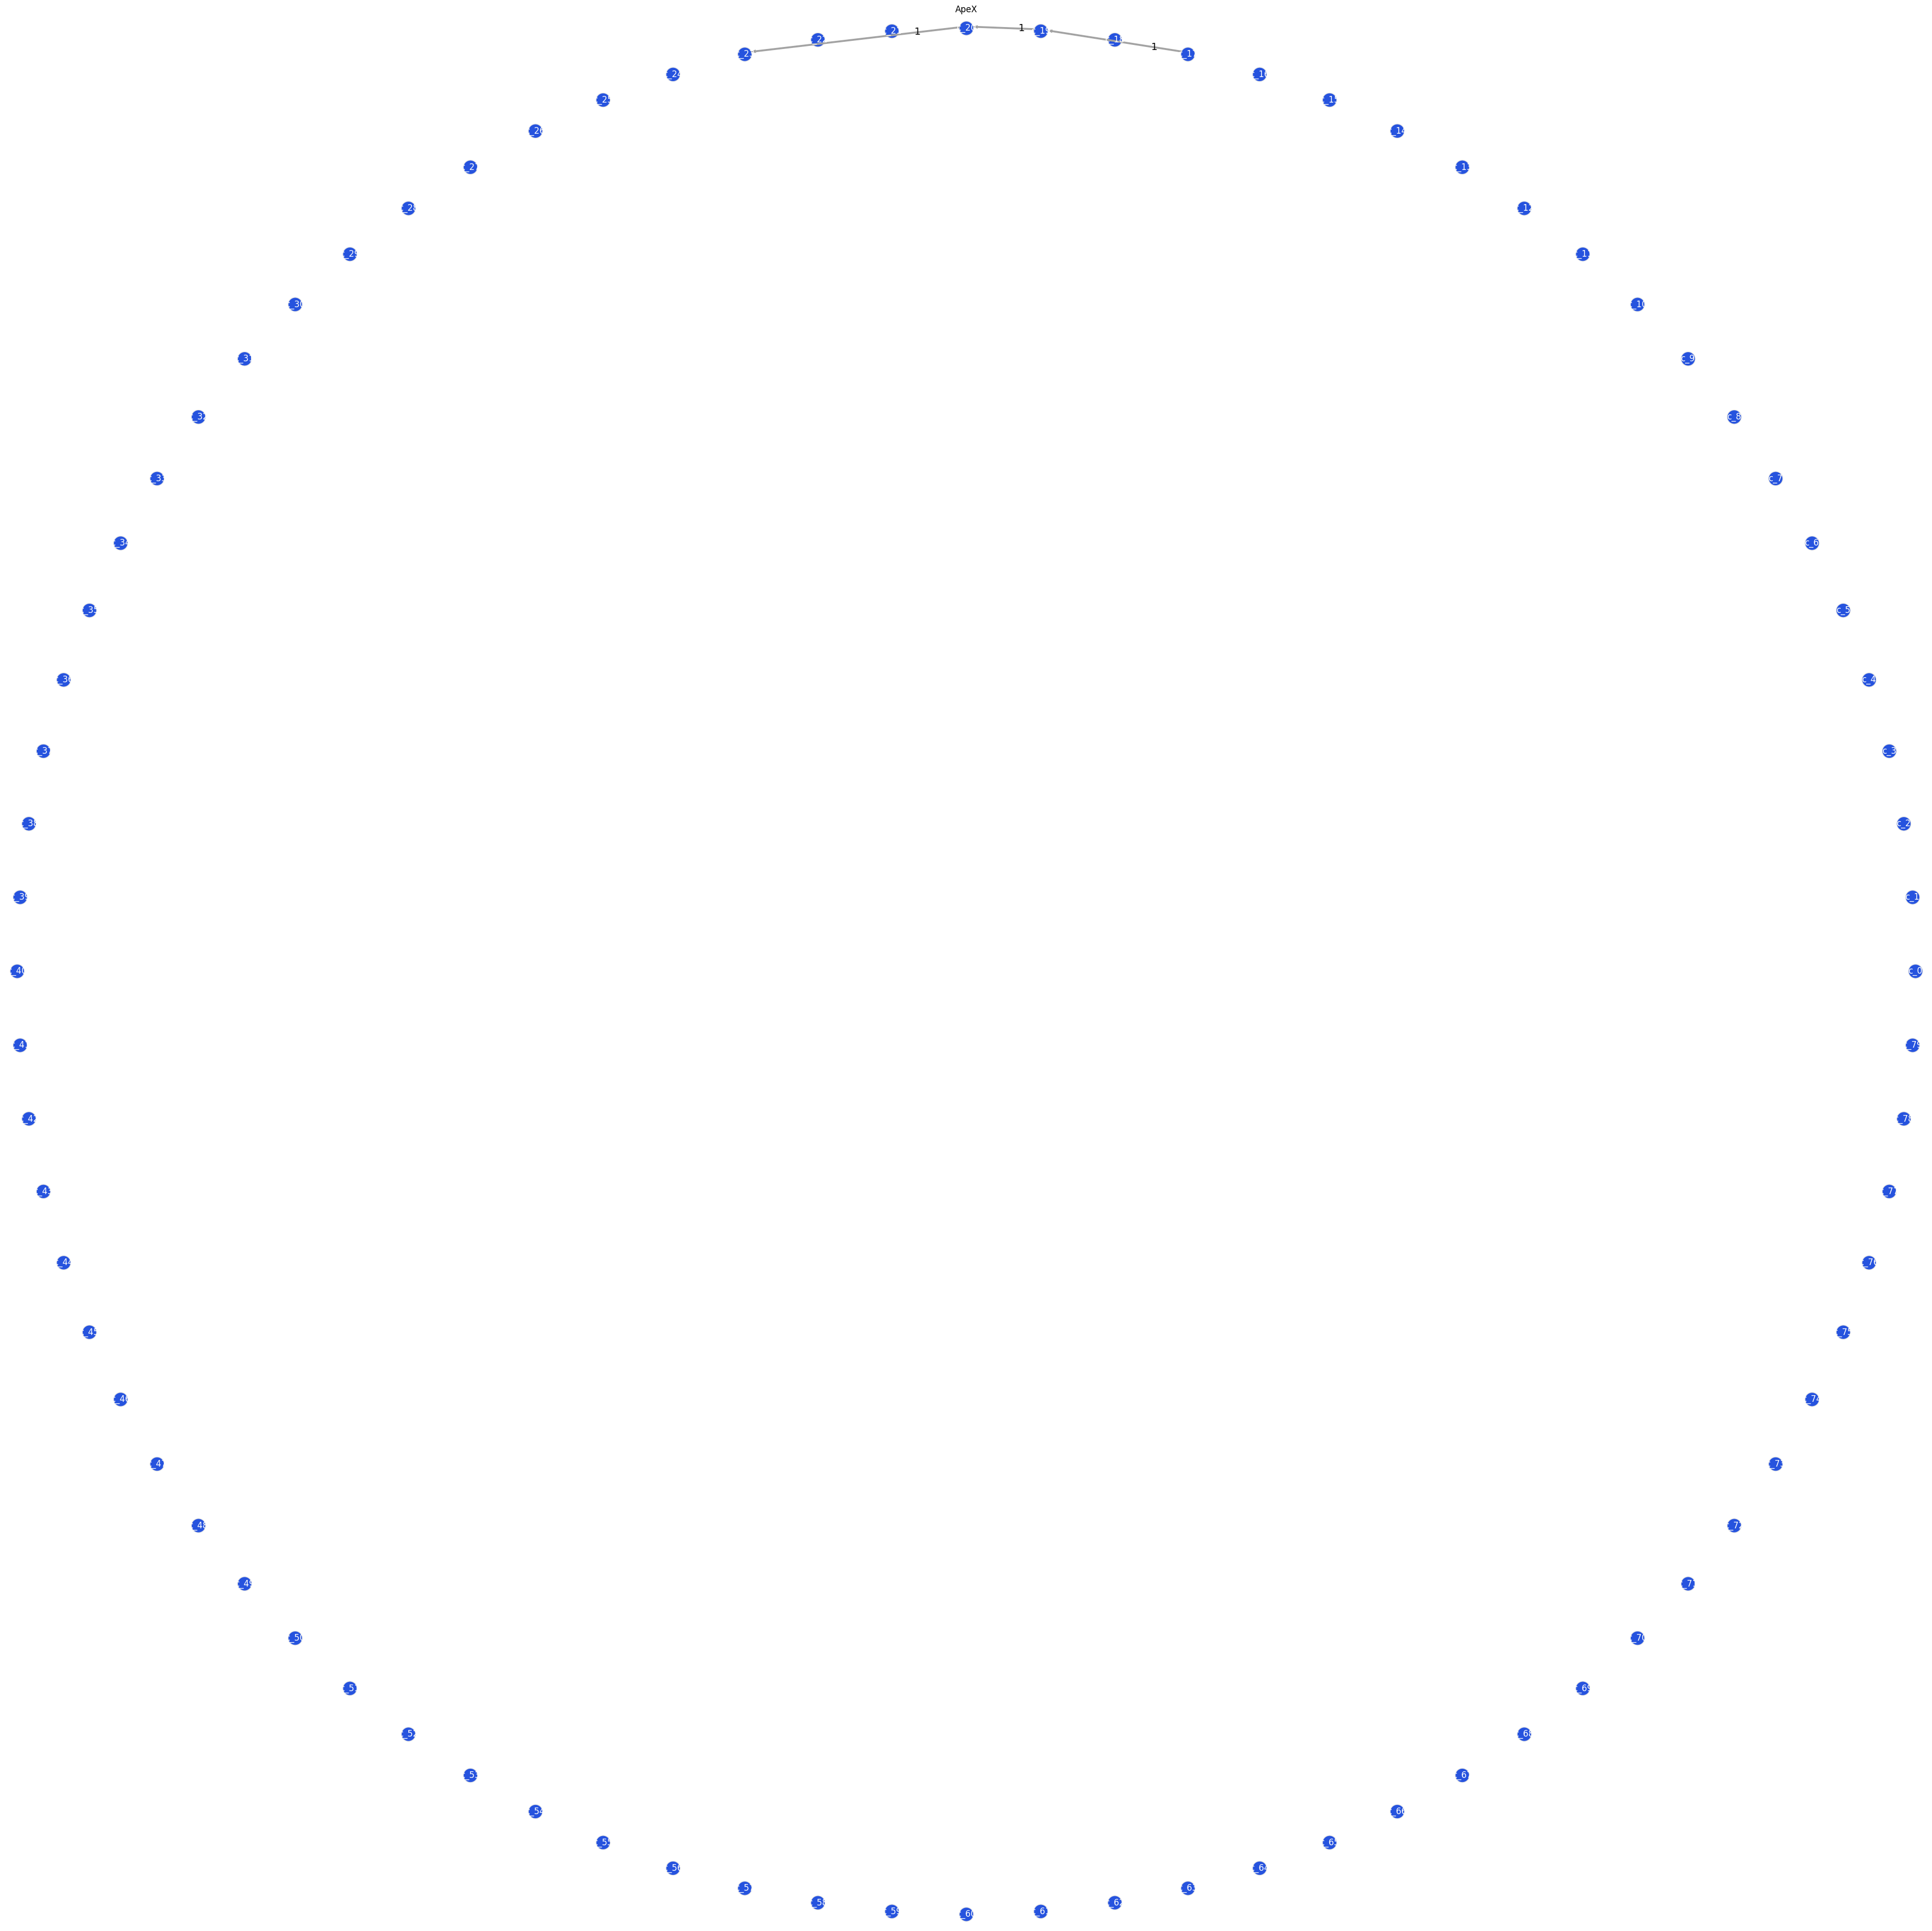

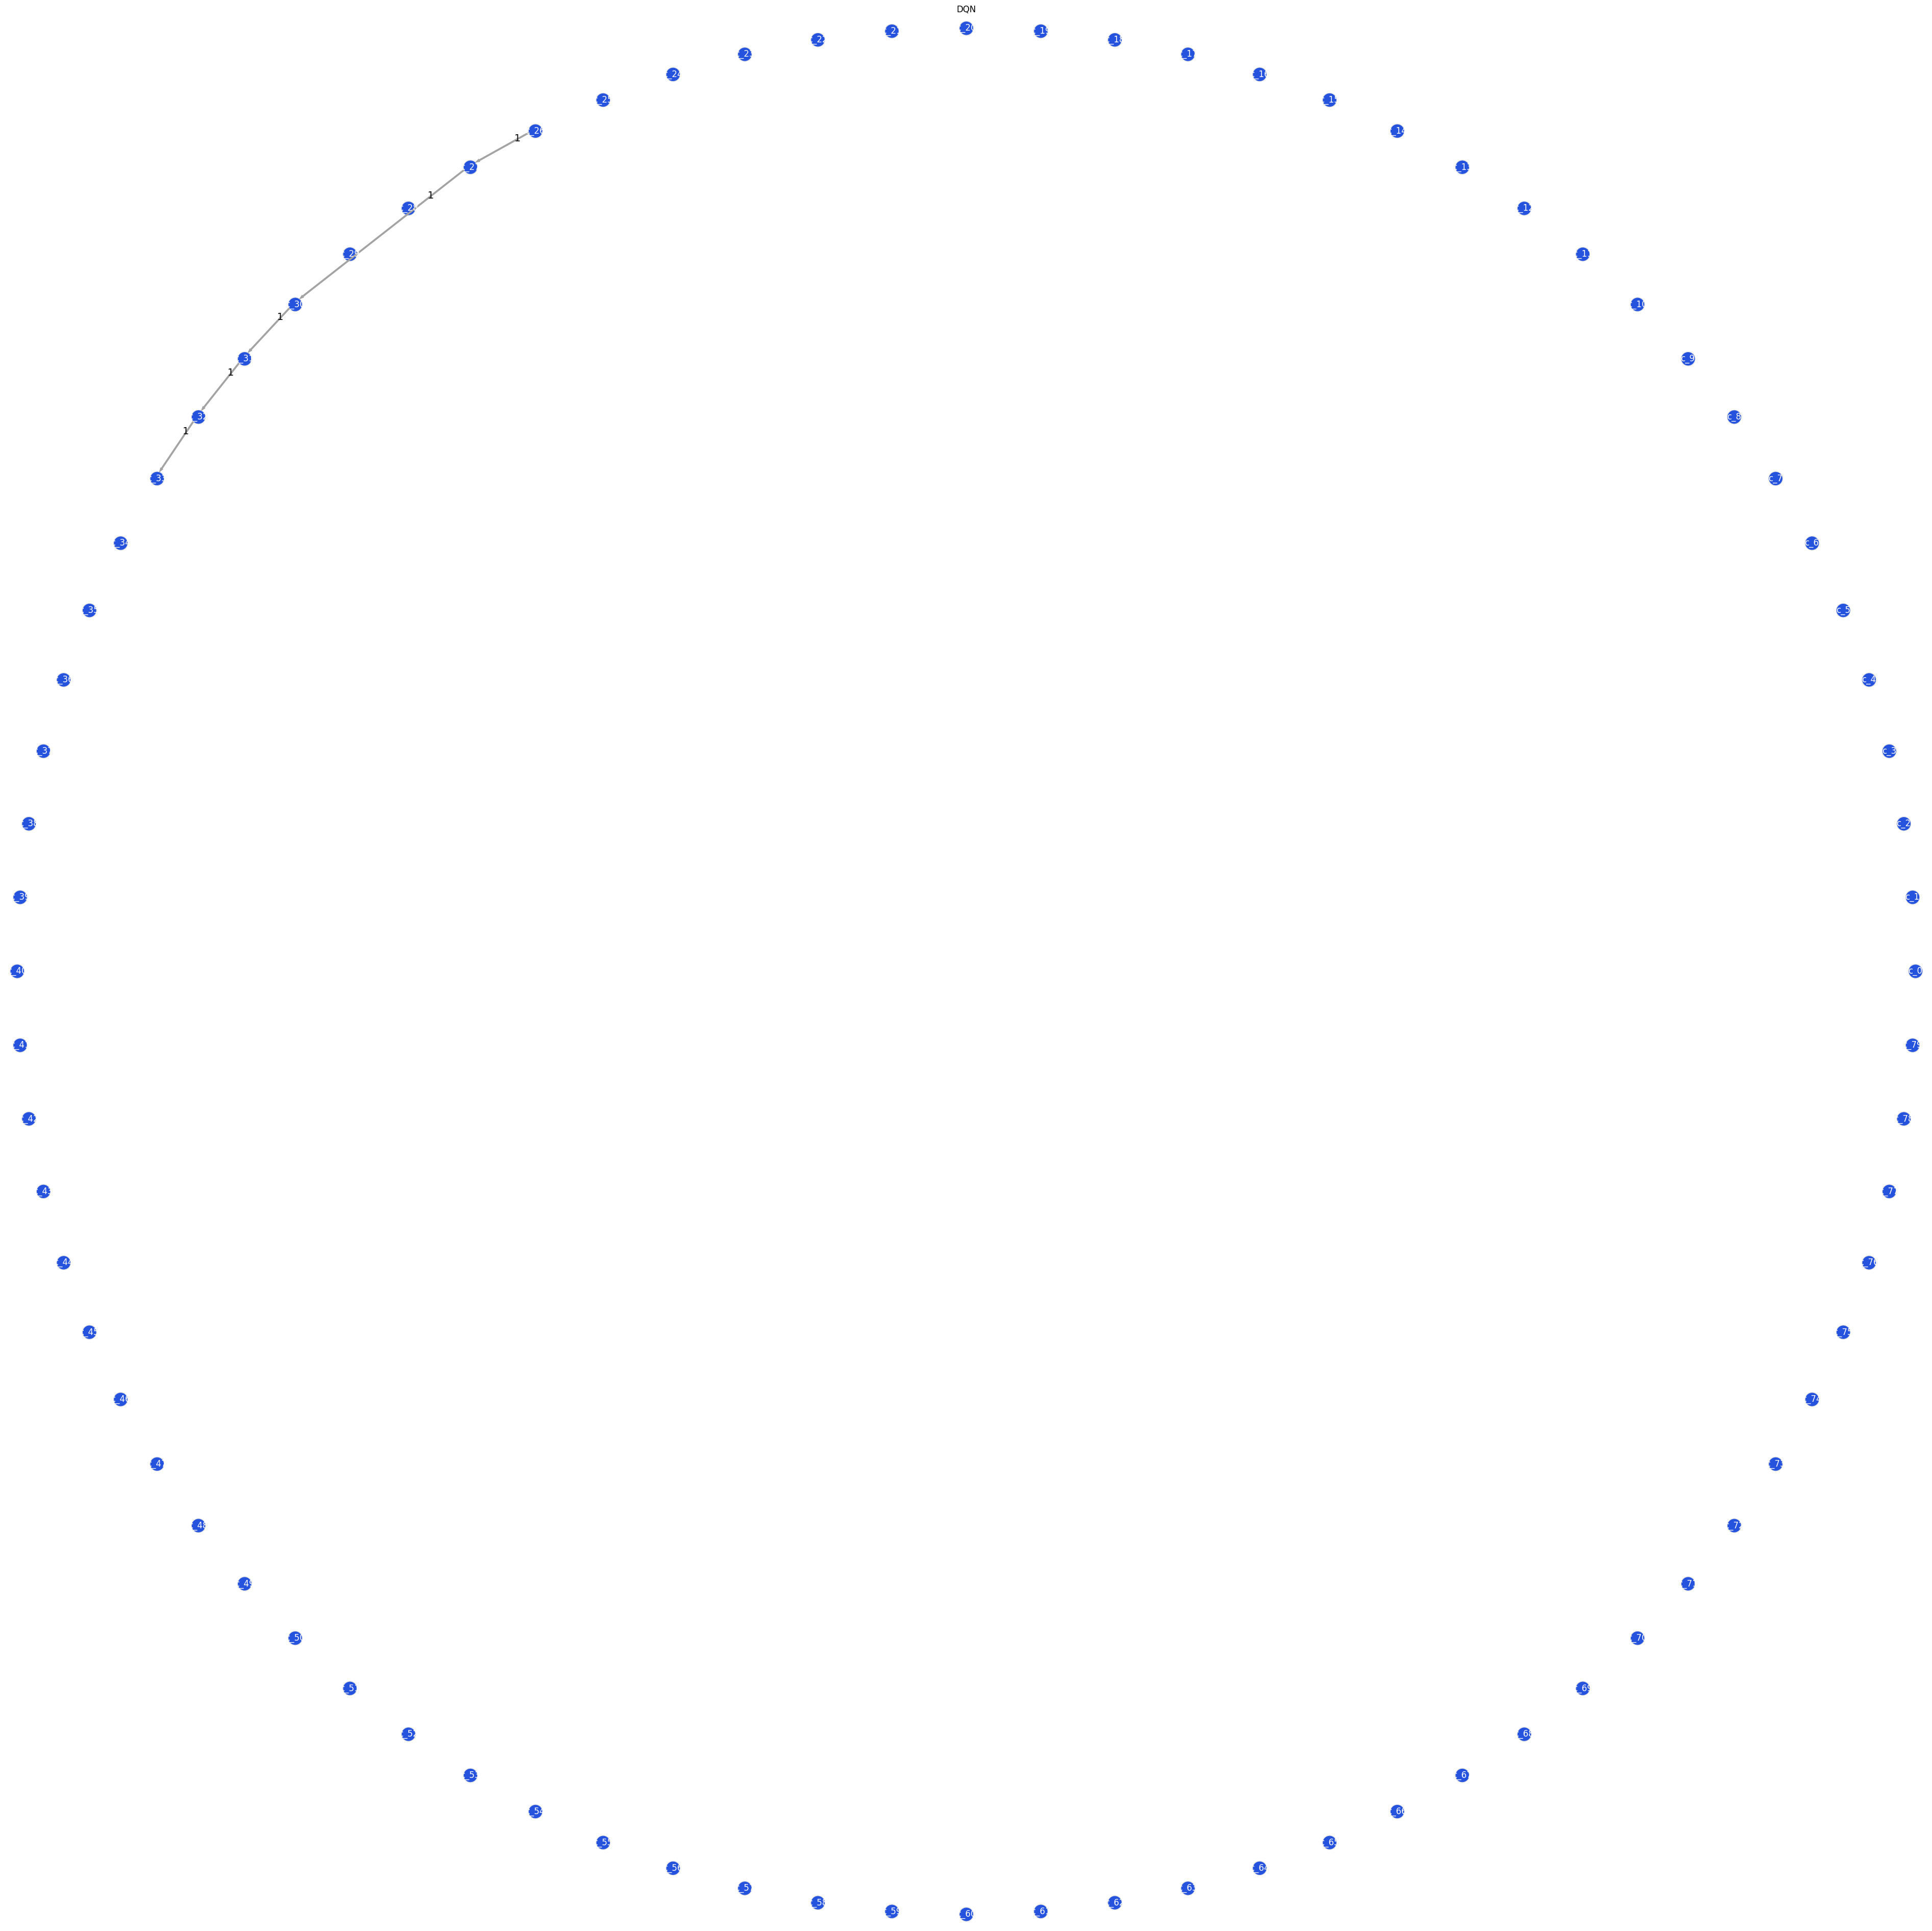

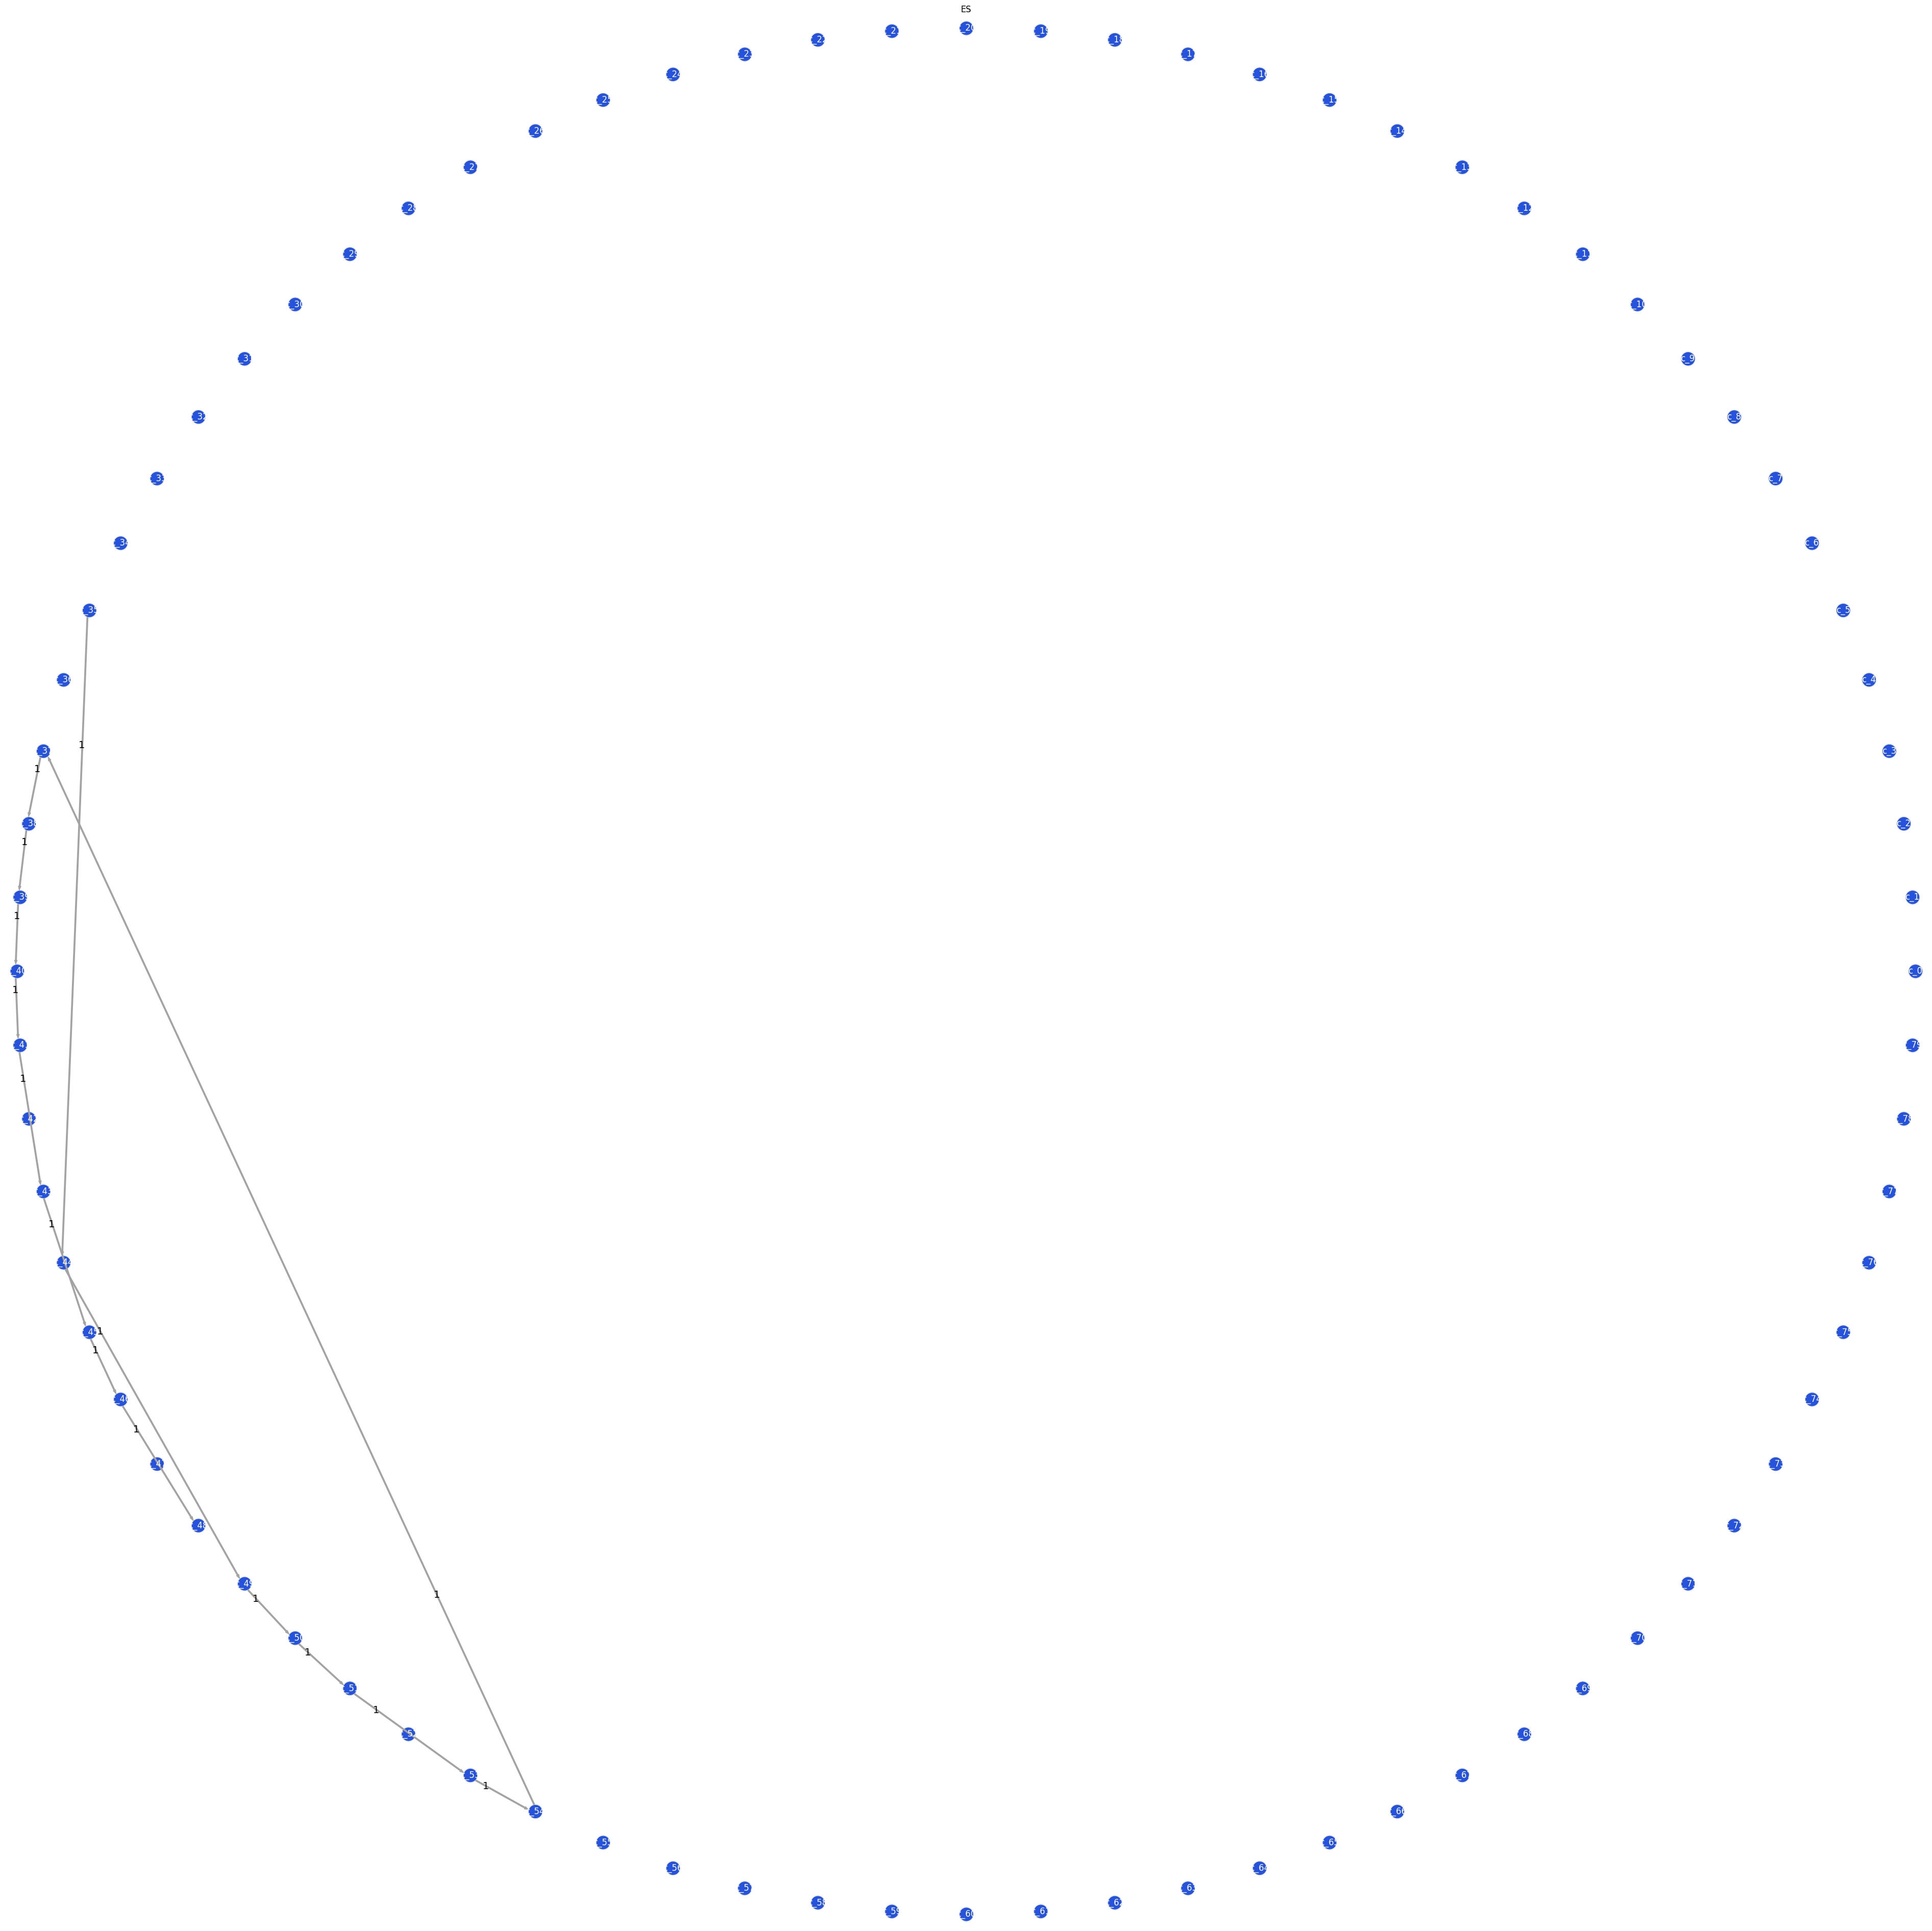

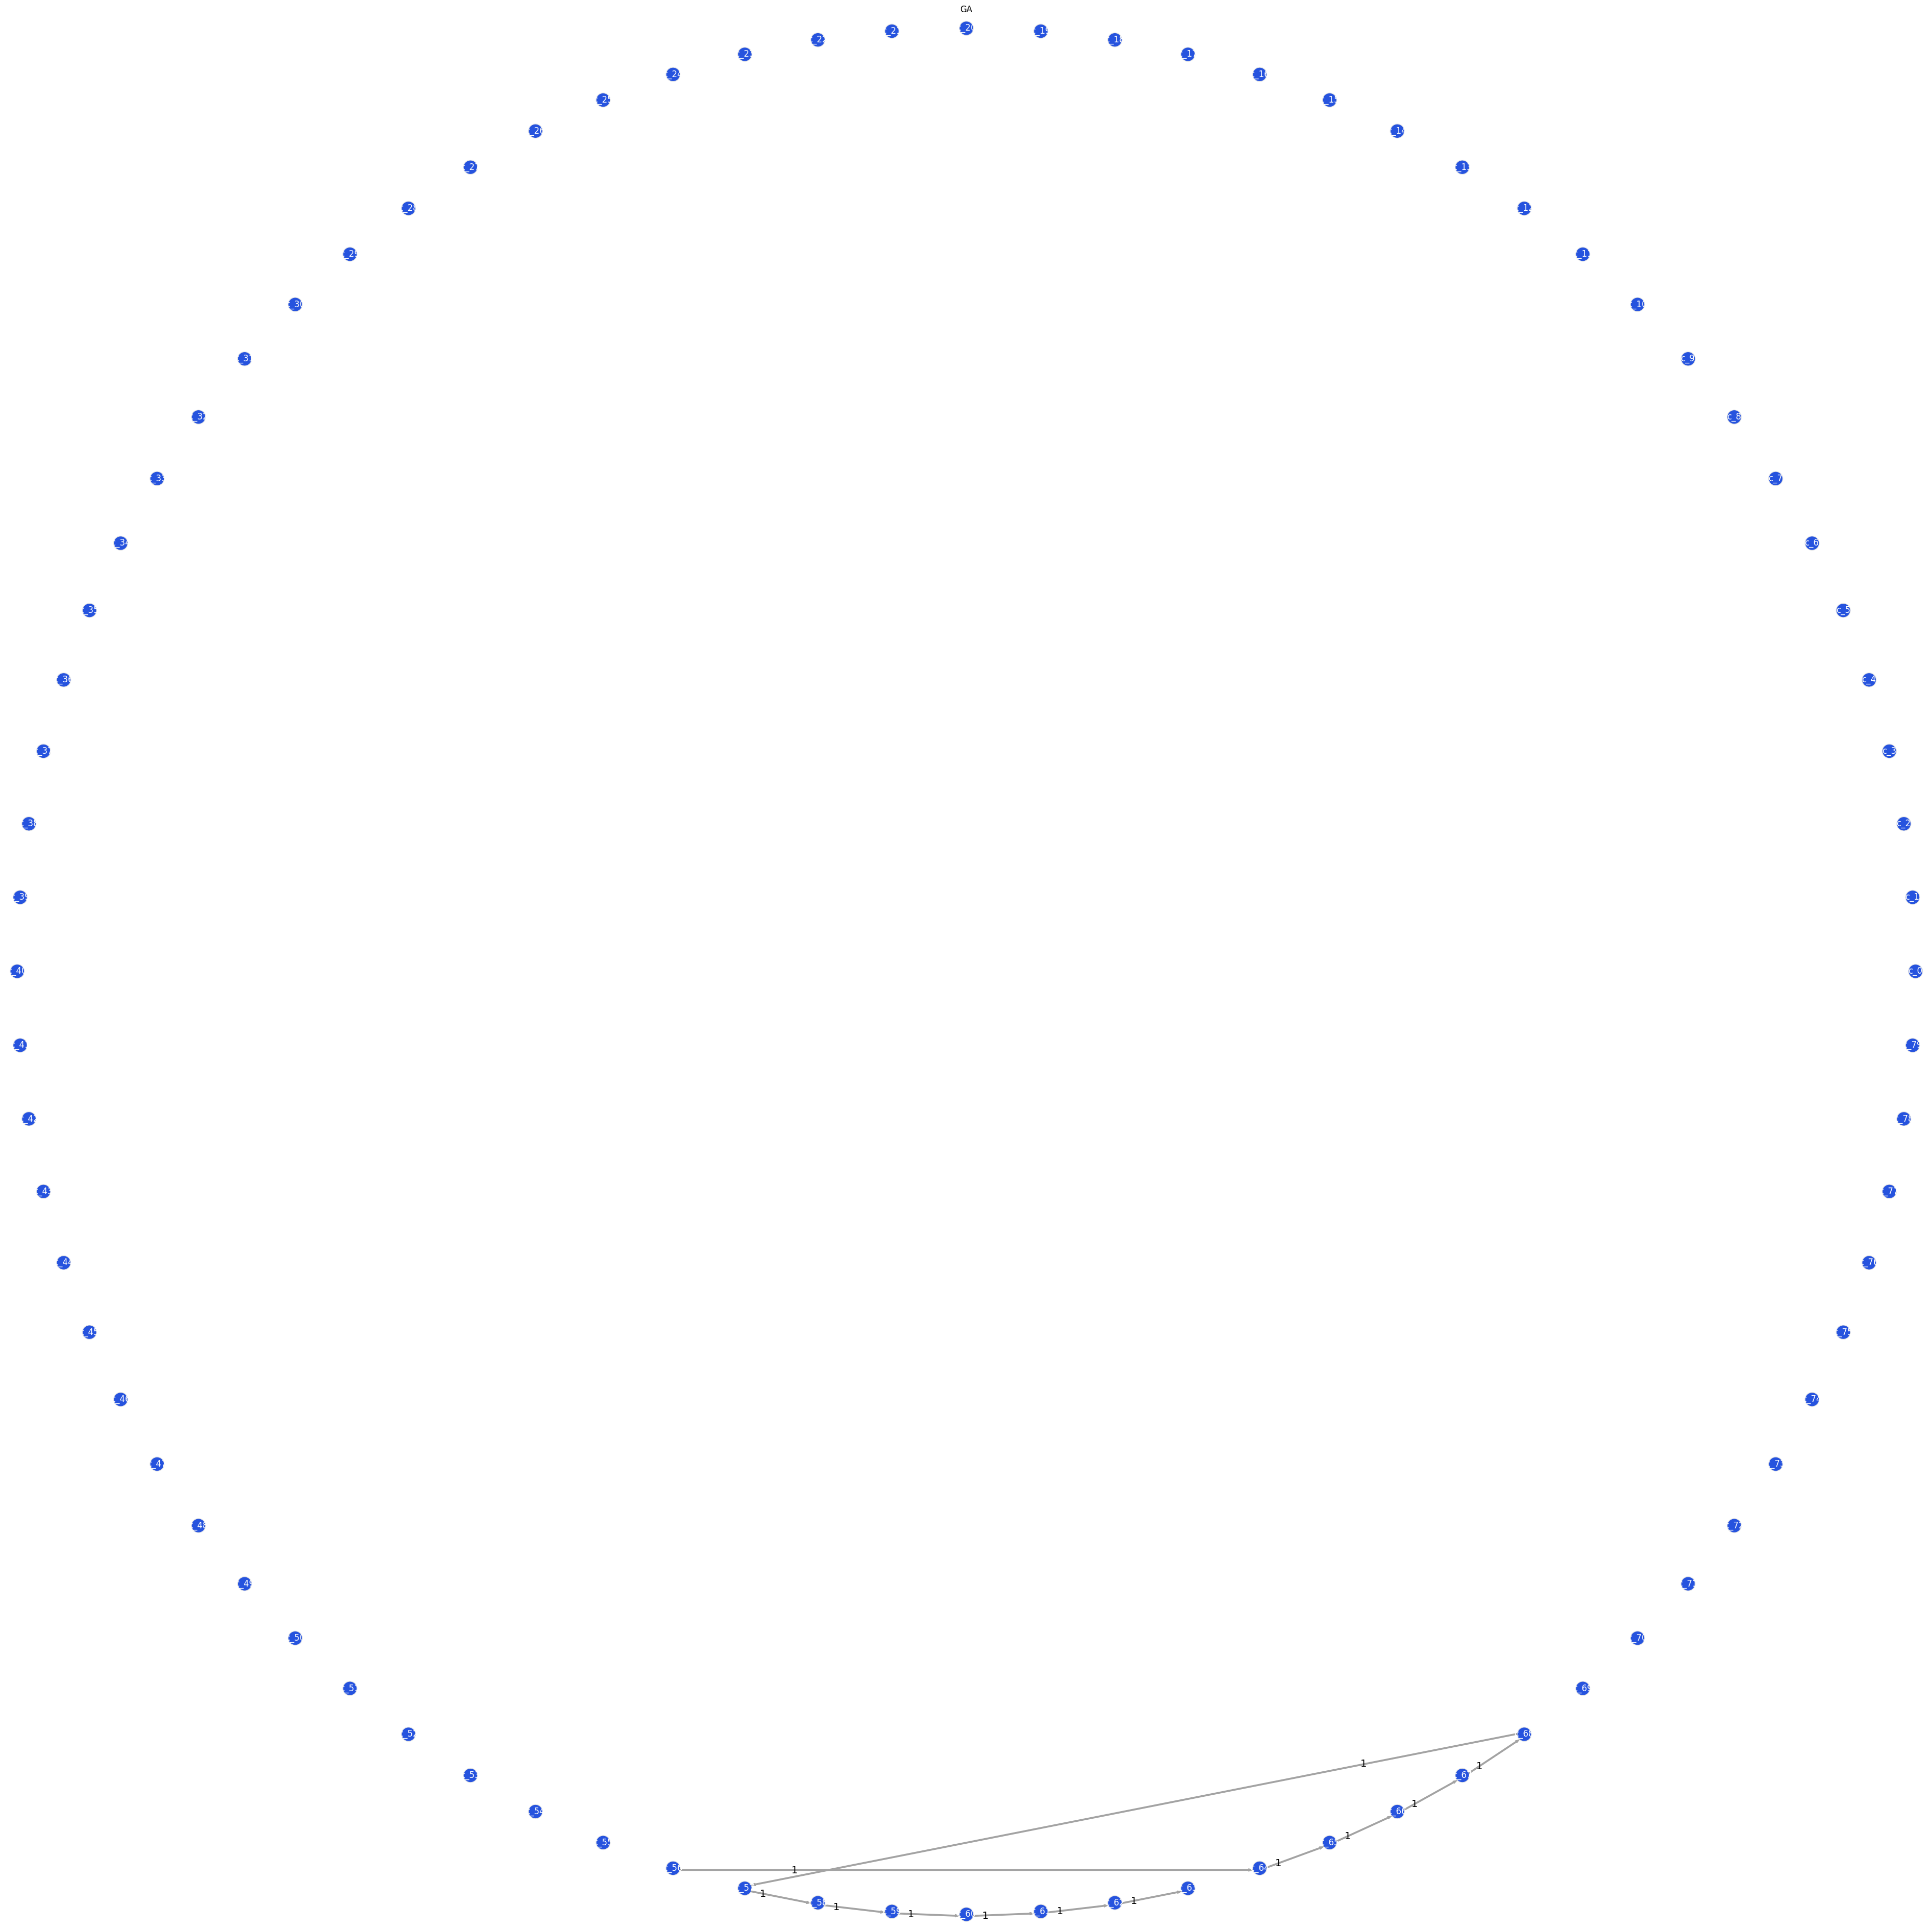

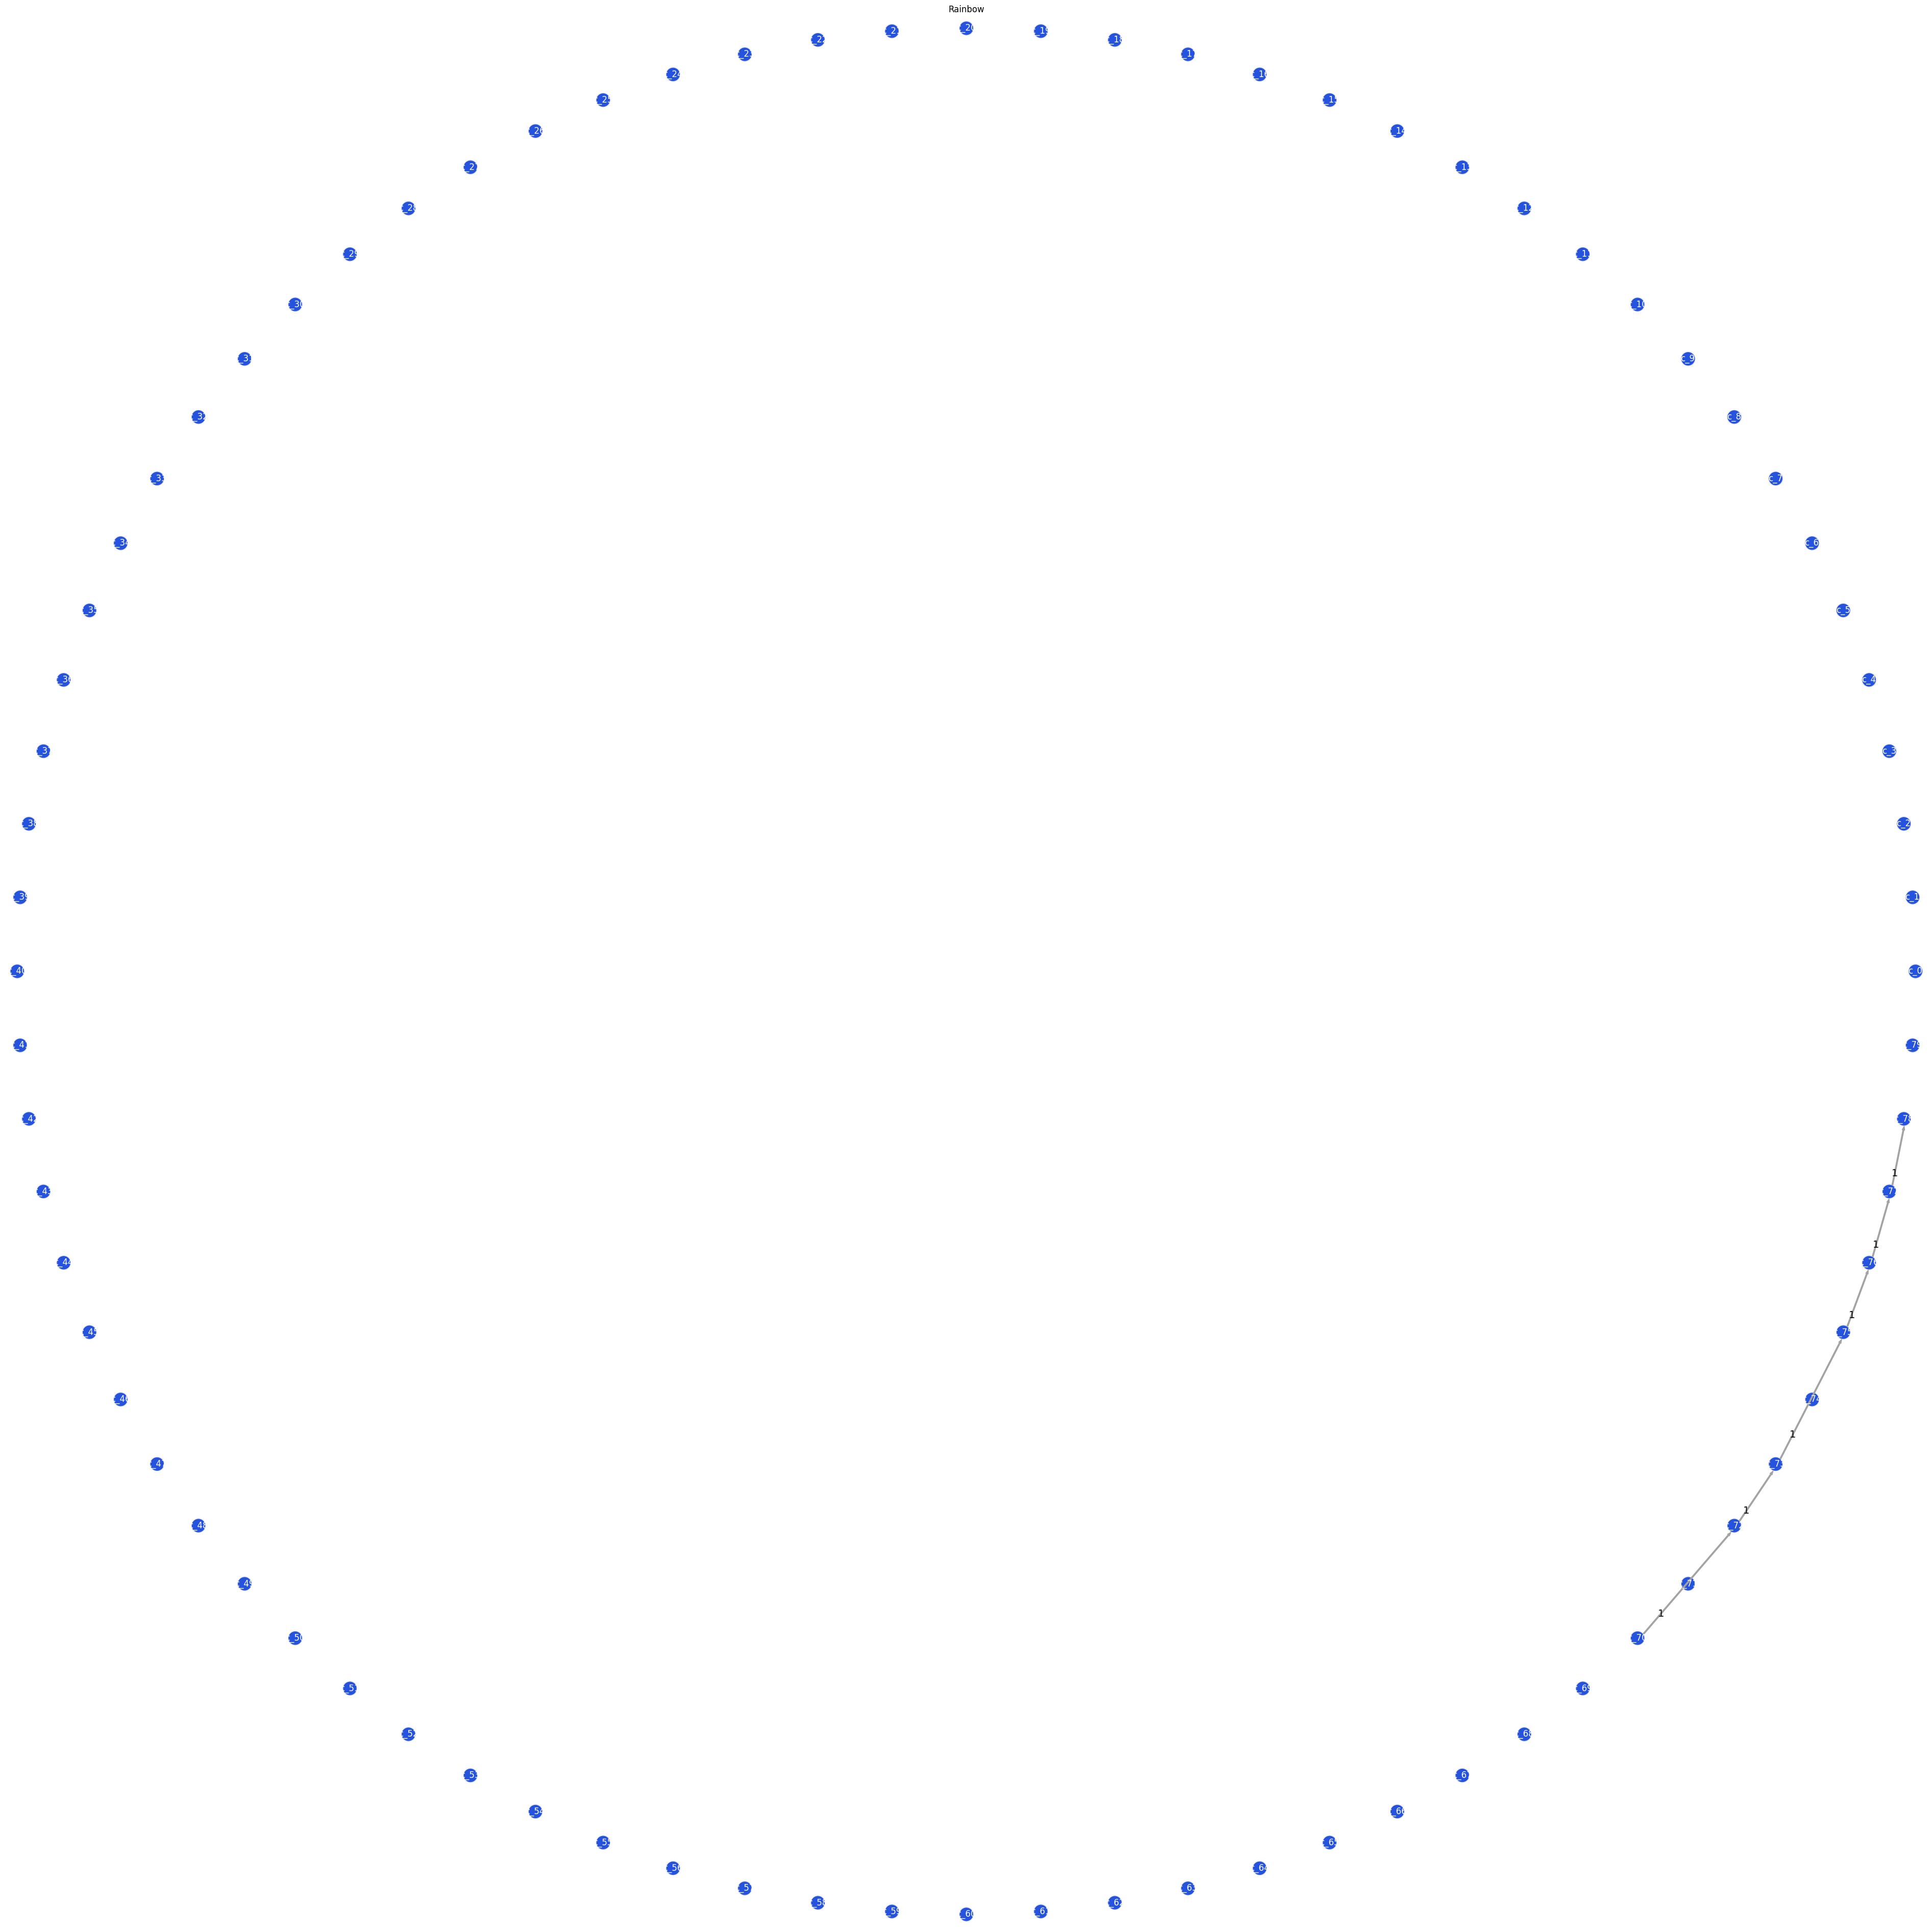

In [314]:
nodes_name = ['c_'+ str(i) for i in range(n_clusters)]

for i in range(len(label_name)):
    mc = MarkovChain(np.array(matrix[i]), nodes_name)
    mc.draw(name=label_name[i])